In [10]:
import pandas as pd
import numpy as np
import shap
import torch
from torch import nn
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import random

from torch.distributions import Categorical


import json

import ast

In [2]:
EVAL_FOLDER = '../evaluations'
META_FOLDER = "../meta"
MODELS_FOLDER = "../models"

In [ ]:
N_OPTIONS = 2
TRAFFIC = "custom-2way-single-intersection3"
MODEL = "option_critic_nn_curriculum_2_options_custom-2way-single-intersection3_250000_steps"
PREFIX = f"{MODEL}_{TRAFFIC}"                                              

In [11]:
N_OPTIONS = 2
TRAFFIC = "3x3grid-3lanes2"
# MODEL = "option_critic_nn_2_options_3x3grid-3lanes2_248400_steps"
# MODEL = "option_critic_nn_curriculum_2_options_3x3grid-3lanes2_248400_steps"
# MODEL = "option_critic_nn_curriculum_2_options_3x3grid-3lanes2_testing_248400_steps"
MODEL = "option_critic_nn_curriculum_2_options_3x3grid-3lanes2_start_min_policy_length_4_248400_steps"
MODEL += "_broken"
PREFIX = f"{MODEL}_{TRAFFIC}"                                              

In [12]:

import torch.nn.init as init


class ReluNetwork(nn.Module):
    def __init__(self, input_size, output_size, device):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, output_size),
        )
        self.to(device)
        # self.apply(self.init_weights)


    def init_weights(self, m):
        if isinstance(m, torch.nn.Linear):
            init.constant_(m.weight, -10.0)  # Initialize weights to large negative values
            if m.bias is not None:
                init.constant_(m.bias, -10.0)  # Initialize biases to large negative values


    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


class MultiDiscreteReluNetwork(nn.Module):
    def __init__(self, input_size, action_sizes, device):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            # nn.Linear(256, n_actions),
        )
        # self.apply(self.init_weights)
        self.heads = nn.ModuleList(
            nn.Linear(256, int(size)) for size in action_sizes
        )
        self.to(device)


    def init_weights(self, m):
        if isinstance(m, torch.nn.Linear):
            init.constant_(m.weight, -10.0)  # Initialize weights to large negative values
            if m.bias is not None:
                init.constant_(m.bias, -10.0)  # Initialize biases to large negative values


    def forward(self, x):
        x = self.flatten(x)
        items = self.linear_relu_stack(x)
        logits = [head(items) for head in self.heads]
        return logits

class QNetwork(nn.Module):
    def __init__(self, obs_size, action_size, device):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(obs_size, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, action_size),
        )
        self.to(device)
        # This is required as otherwise it's possible that the random
        # initialization of the weights will cause the network to output
        # a higher Q value for a state/option pair for which we did not train
        # This because the rewards tend to be negative
        # self.apply(self.init_weights)


    def init_weights(self, m):
        if isinstance(m, torch.nn.Linear):
            init.constant_(m.weight, -10.0)  # Initialize weights to large negative values
            if m.bias is not None:
                init.constant_(m.bias, -10.0)  # Initialize biases to large negative values


    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


class TerminationFunctionNetwork(nn.Module):
    """This neural network predicts the probability of terminating an option.
    """
    def __init__(self, obs_size, n_options, device):
        super().__init__()  
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(obs_size, 256),
            nn.Tanh(),
            # nn.Linear(256, 256),
            # nn.LeakyReLU(),
            nn.Linear(256, n_options),
        )
        self.to(device)
        self.apply(self.init_weights)
    
    def init_weights(self, m):
        if isinstance(m, torch.nn.Linear):
            init.xavier_uniform_(m.weight)  # Xavier initialization
            if m.bias is not None:
                init.constant_(m.bias, random.uniform(0, 1))

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [13]:
def to_tensor(obs):
    obs = np.asarray(obs)
    obs = torch.from_numpy(obs).float()
    return obs

def load_data(prefix, traffic):
    with open(f"{META_FOLDER}/{traffic}.json") as f:
        meta_data = json.load(f)
    def translate_action(action):
        # TODO: add fix in evaluate script
        if action.startswith("["):
            action = action.replace("  ", " ").replace("[ ", "[").replace(" ", ", ").replace(",,", ",")
        action = ast.literal_eval(action)
        tf_ids = list(ast.literal_eval(df_single_episode.obs.to_list()[0]).keys())
        n_splits = len(action)
        if isinstance(action, list):
            if len(action) == 1:
                action_dict = {tf_ids[0]: action[0]}  # TODO: rename traffic signal in single traffic light scenario
            else:
                action_dict = {tf_ids[i]: a 
                              for i, a in enumerate(action)}
        
        green = []
        for tf_id, p in action_dict.items():
#             print(tf_id, p , meta_data[tf_id]["phases"])
            green_tf = f"{tf_id}:"
            green_tf += ", ".join(meta_data[tf_id]["phases"][str(p)]["lanes_green"])
            green.append(green_tf)
        return "; ".join(green)
    print("Loading", f'{EVAL_FOLDER}/{prefix}_{traffic}_1_episode.csv')
    df_single_episode = pd.read_csv(f'{EVAL_FOLDER}/{prefix}_{traffic}_1_episode.csv')
    df_single_episode = df_single_episode.set_index('step')
    df_single_episode = df_single_episode.drop(columns=['cumulative_reward'])
    df_single_episode["translated_action"]= df_single_episode['action'].apply(
        lambda x: translate_action(x)
    )
    n_splits = len(df_single_episode.translated_action.to_list()[0].split("; "))
    df_single_episode[[f"translated_action_tf_{i}"
                      for i in range(n_splits)]] = df_single_episode['translated_action'].str.split('; ', expand=True)
    
    
    # df_multiple_episodes = pd.read_csv(f'{EVAL_FOLDER}/{prefix}_{traffic}_100_episode.csv')
    # df_multiple_episodes = df_multiple_episodes.set_index('episode')
    # df_multiple_episodes = df_multiple_episodes.drop(columns=['cumulative_reward'])
    df_multiple_episodes = None
    return df_single_episode, df_multiple_episodes

def get_obs(df, index):
    current_option = df.option.to_list()[index]
    total_observation = []
    unnested_obs = {}
    
    with open(f"{META_FOLDER}/{TRAFFIC}.json") as f:
        meta_data = json.load(f)
    
    for tf_id, observation_dict in json.loads(df.obs.to_list()[index]).items():        
        # current_time = observation_dict["current_time"]
        phase_ids = observation_dict["current_phase_ids"]
        # phase_ids = observation_dict["hist_phase_ids"]
        # min_green = observation_dict["min_green"]
        # density = observation_dict["density"]
        queue = observation_dict["queue"]
        # queue_der = observation_dict["queue_der"]
        # average_speed = observation_dict["average_speed"]
        waiting_times = []
        for waiting_time in observation_dict["waiting_times"]:
            if waiting_time:
                waiting_times.append(np.max(waiting_time))
            else:
                waiting_times.append(0)
        # observation = np.array(phase_ids + queue + queue_der + waiting_times + [average_speed], dtype=np.float32)
        observation = np.array(phase_ids + queue + waiting_times, dtype=np.float32)
        # TODO: check if I can update the phase ids?
        # TODO: double check queue_der
        tf_meta_data = meta_data[tf_id]        
        
        total_observation.extend(observation)
        for key, value in observation_dict.items():           
            if isinstance(value, list):
                for index, item in enumerate(value):
                    suffix = index
                    if key in ["queue", "waiting_times"]:
                        suffix = tf_meta_data["lanes"]["incoming"][str(index)]
                    unnested_obs[f"{tf_id}_{key}_{suffix}"] = item
            else:
                unnested_obs[f"{tf_id}_{key}"] = value
    total_observation = np.array(total_observation, dtype=np.float32)
    encoded_option = np.zeros(N_OPTIONS)
    encoded_option[current_option] = 1
    total_observation = np.append(total_observation, encoded_option)
    
    for o in range(N_OPTIONS):
        key = f"option_{o}"
        if o == current_option:
            value = 1
        else:
            value = 0
        unnested_obs[f"{tf_id}_{key}"] = value

    return total_observation, current_option, unnested_obs

def get_random_obs(df):
    index = random.randrange(df.shape[0])
    return get_obs(df, index)

def prep_state(obs, current_option):
    """Convert the provided observation to a tensor

    Args:
        obs (Any): Obs provided by the environment
    """

    # Unnest observation
    obs_array = []
    if isinstance(obs, dict):
        for _, obs_arr in obs.items():
            obs_array.extend(obs_arr)
    else:
        obs_array.extend(obs)


    # include option information
    # Simplified to make it easier to manage
    encoded_option = np.zeros(N_OPTIONS)
    encoded_option[current_option] = 1
    obs = np.append(obs, encoded_option)

    # Convert to tensor
    obs_tensor = to_tensor(obs_array)
    if obs_tensor.ndim < 4:
        obs_tensor = obs_tensor.unsqueeze(0)
    obs_tensor = obs_tensor.to("cpu")
    return obs_tensor


In [14]:
df_single_episode, _ = load_data(MODEL, TRAFFIC)

Loading ../evaluations/option_critic_nn_curriculum_2_options_3x3grid-3lanes2_start_min_policy_length_4_248400_steps_broken_3x3grid-3lanes2_1_episode.csv


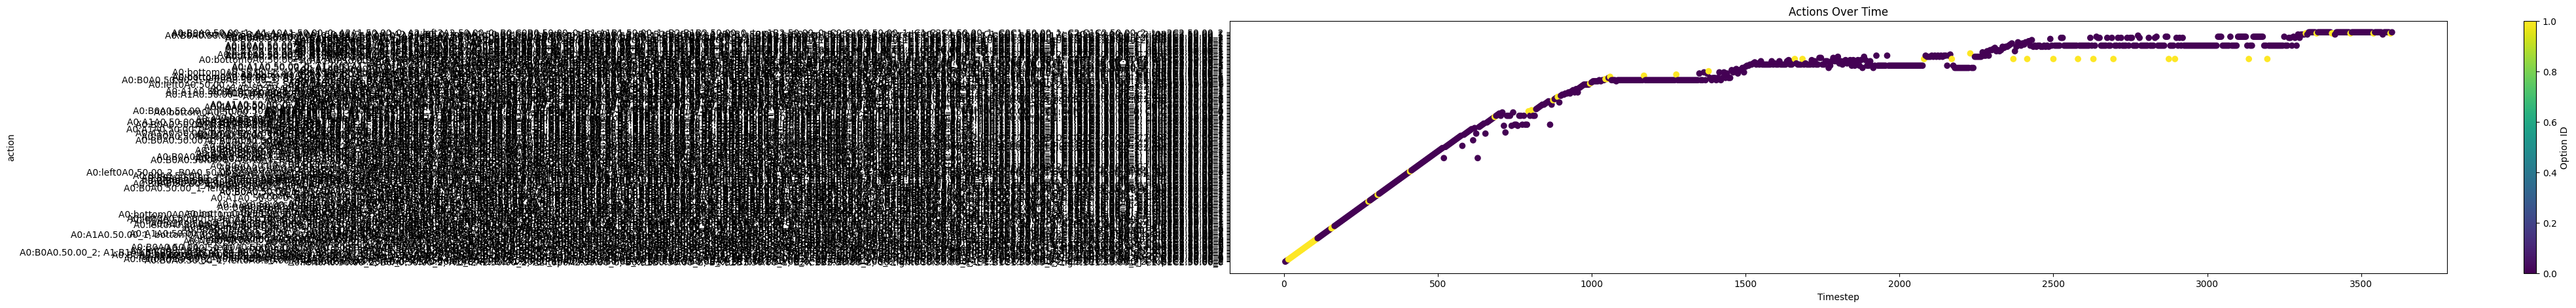

In [15]:
plt.figure(figsize=(30, 5))
plt.scatter(df_single_episode.index, df_single_episode.translated_action, c=df_single_episode.option)
plt.xlabel("Timestep")
plt.ylabel("action")
plt.title("Actions Over Time")
plt.colorbar(label="Option ID")
plt.show()

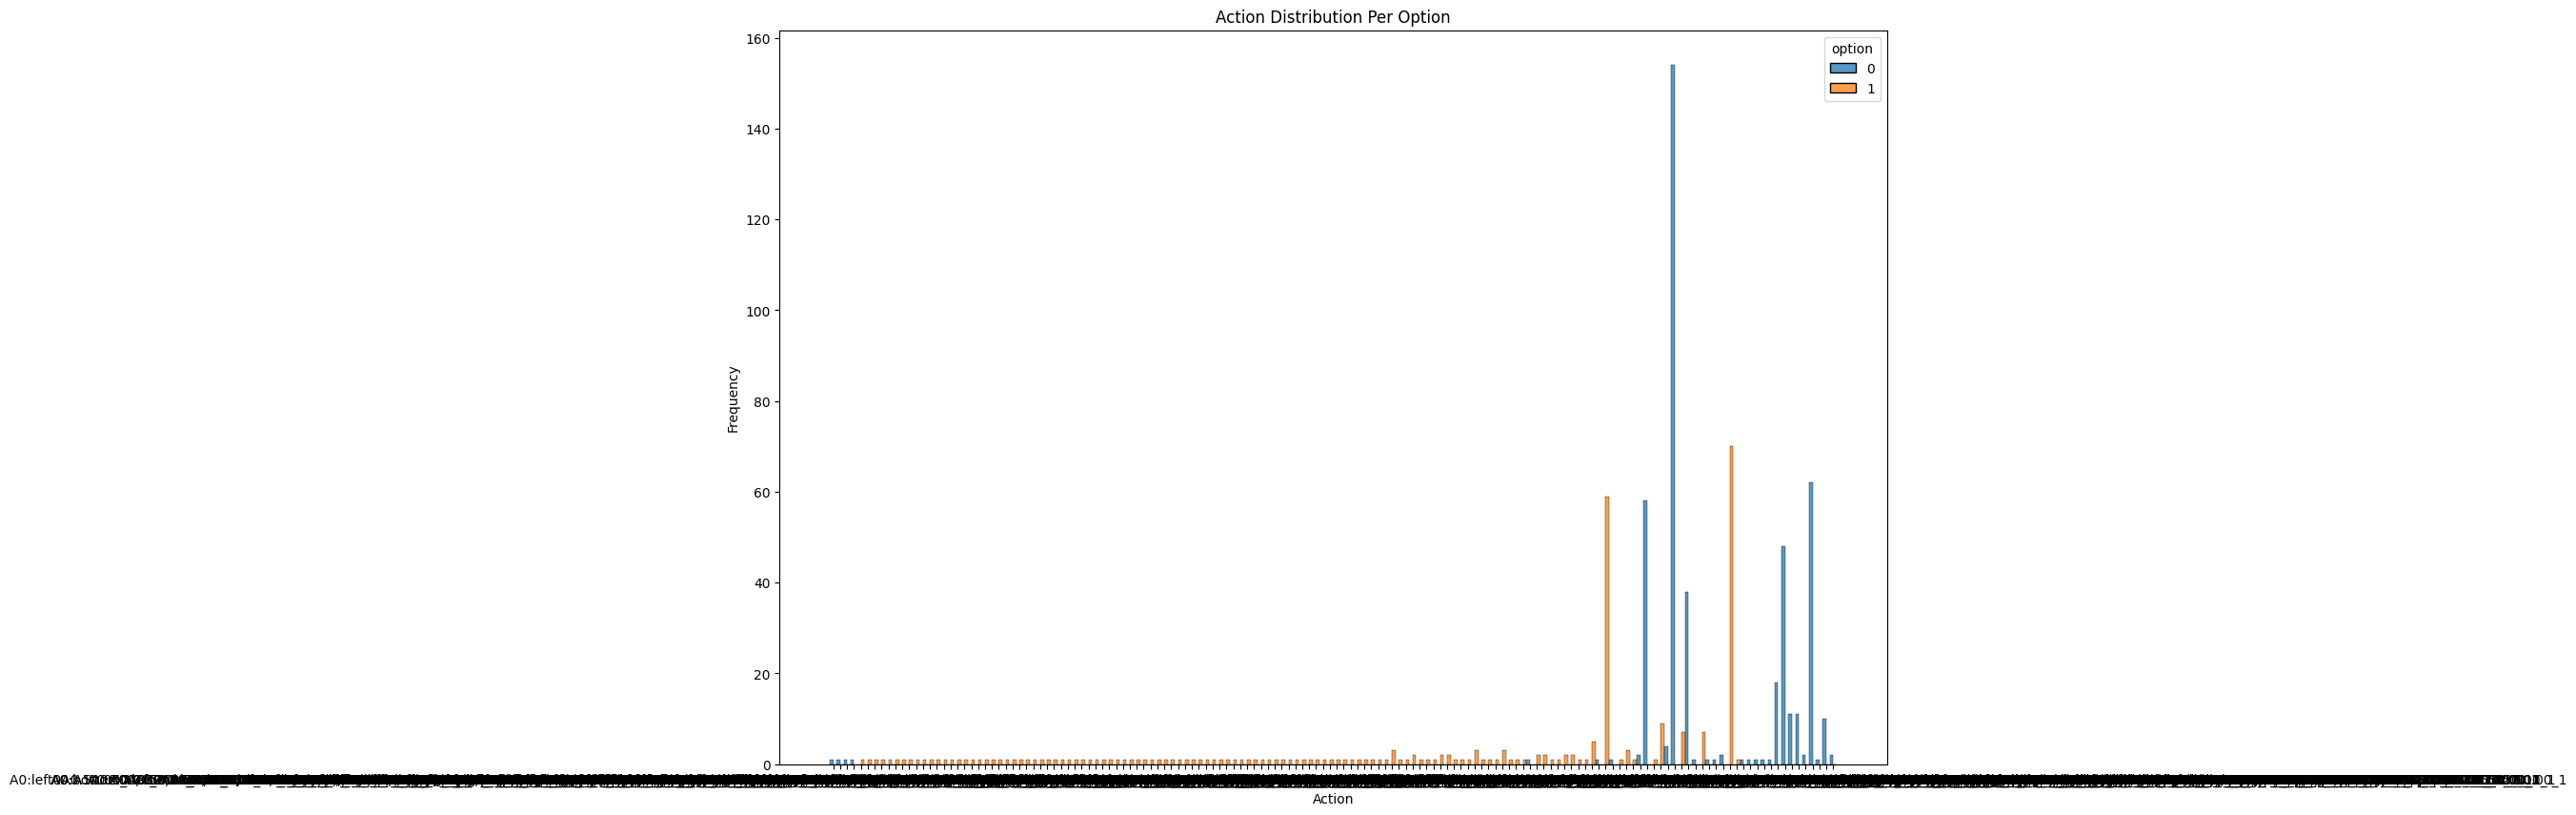

In [8]:
plt.figure(figsize=(15, 10))
sns.histplot(df_single_episode, x="translated_action", hue="option", multiple="dodge", palette="tab10")
plt.xlabel("Action")
plt.ylabel("Frequency")
plt.title("Action Distribution Per Option")
plt.show()

Results 3x3grid-3lanes translated_action_tf_0


/tmp/ipykernel_124445/2831421036.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


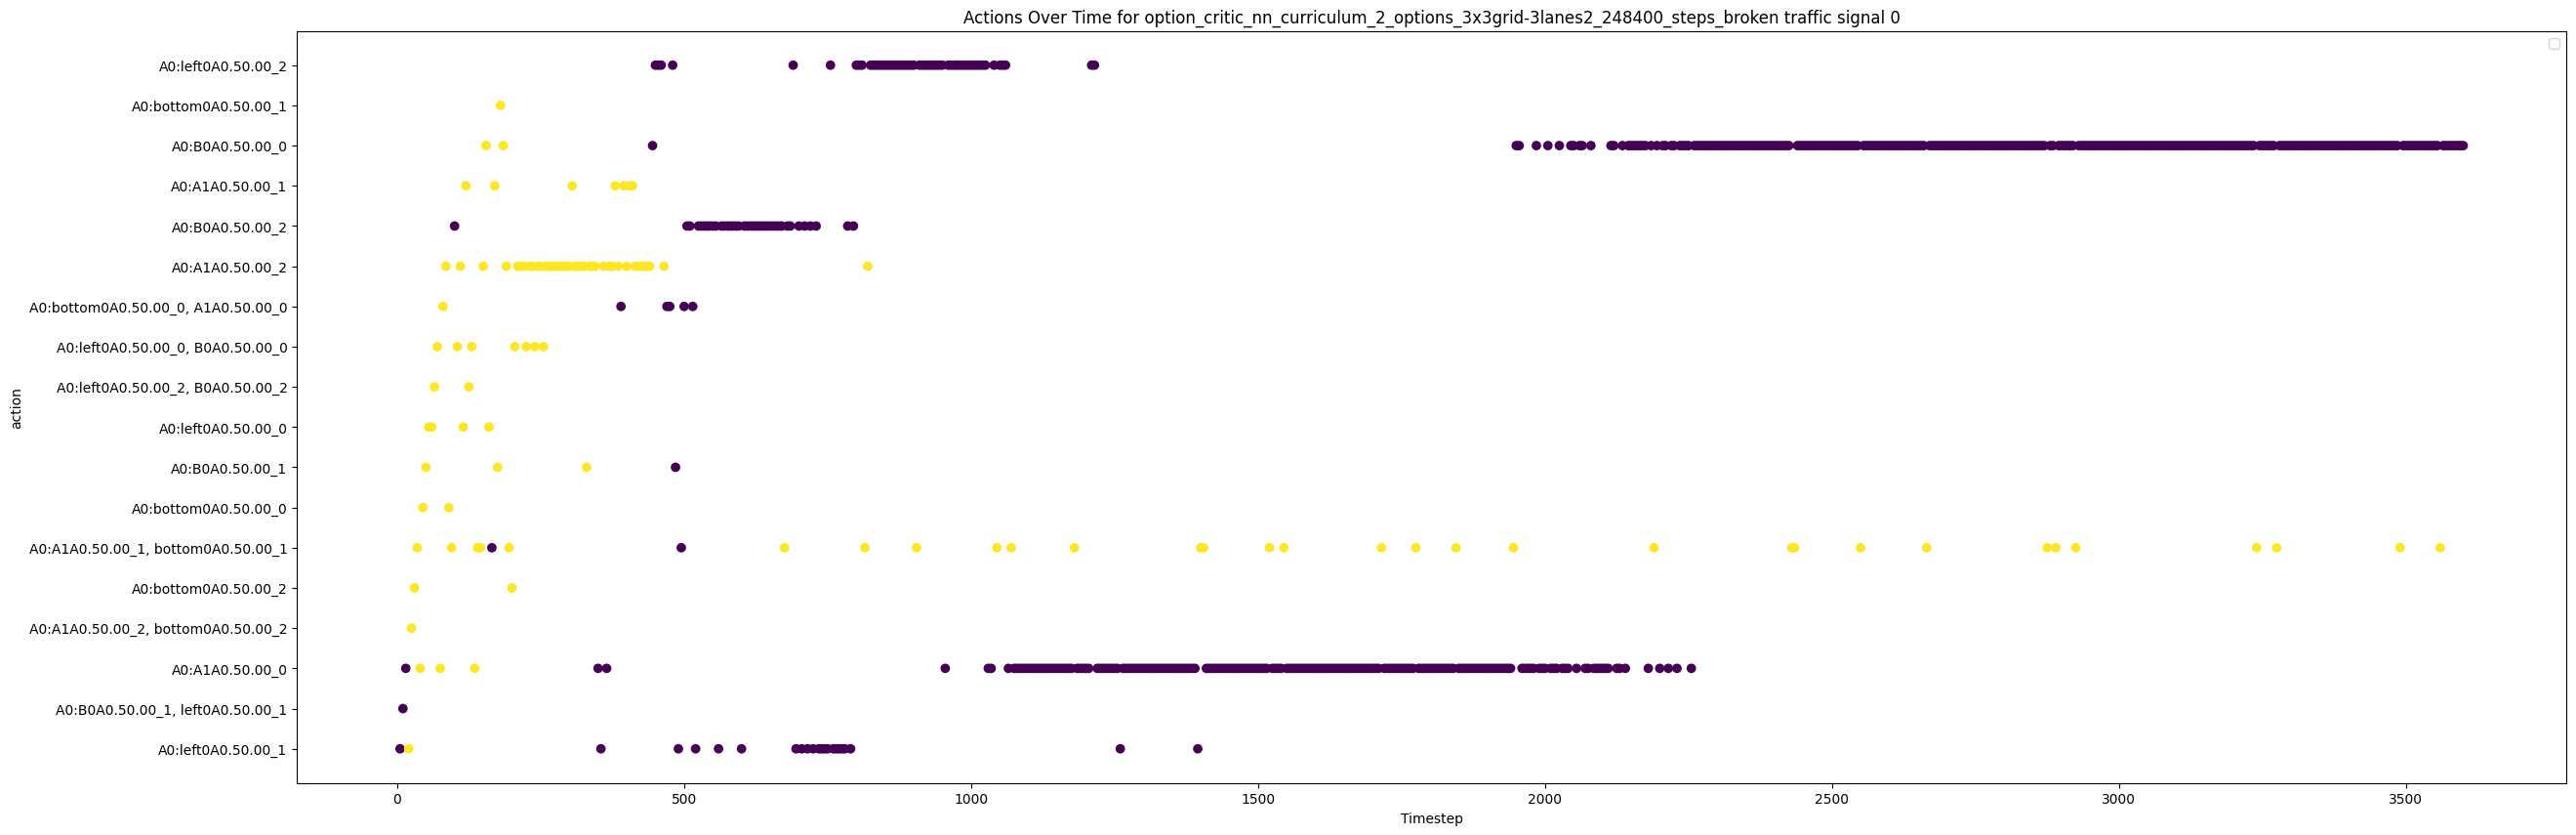

/tmp/ipykernel_124445/2831421036.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


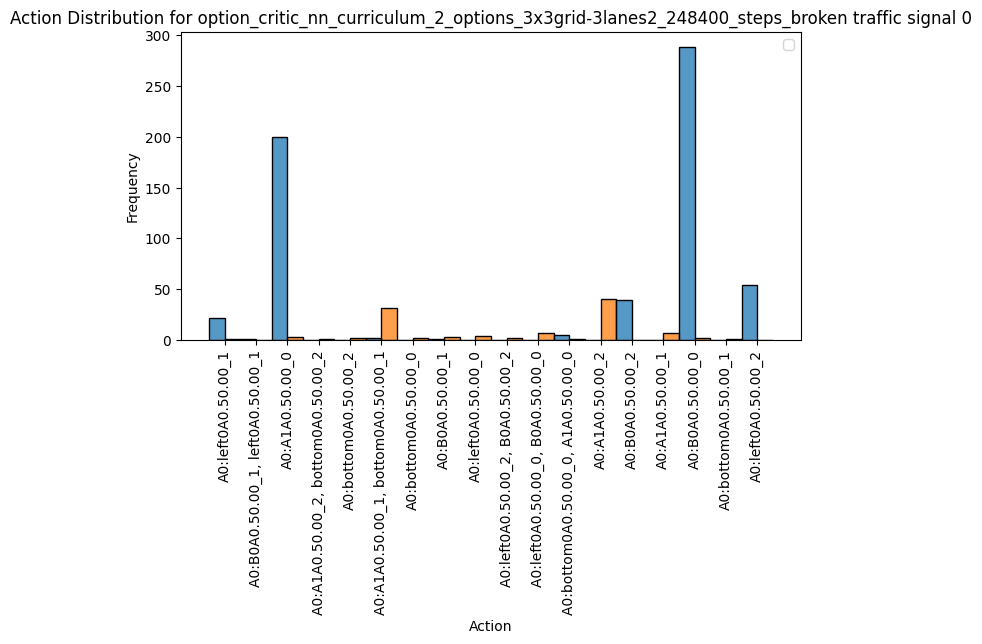

/tmp/ipykernel_124445/2831421036.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Results 3x3grid-3lanes translated_action_tf_1


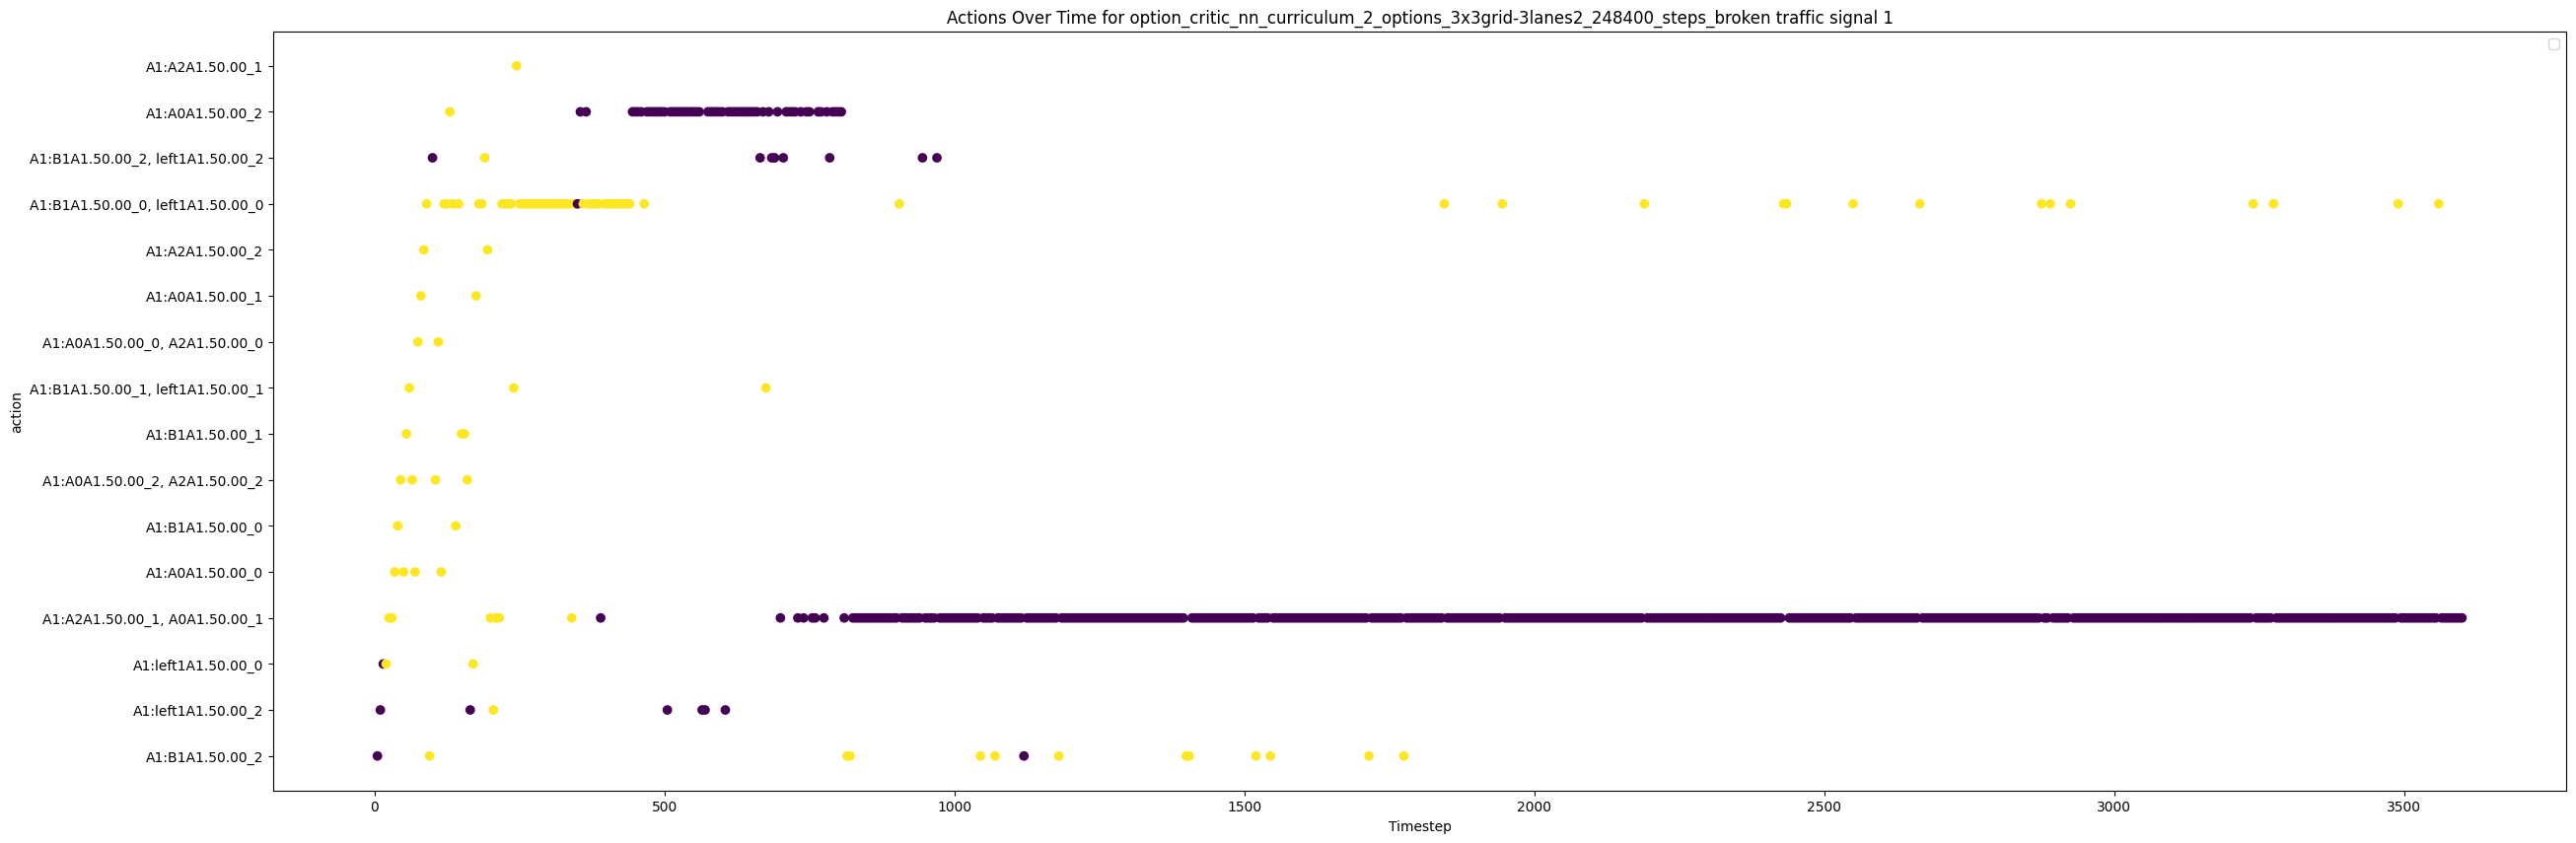

/tmp/ipykernel_124445/2831421036.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


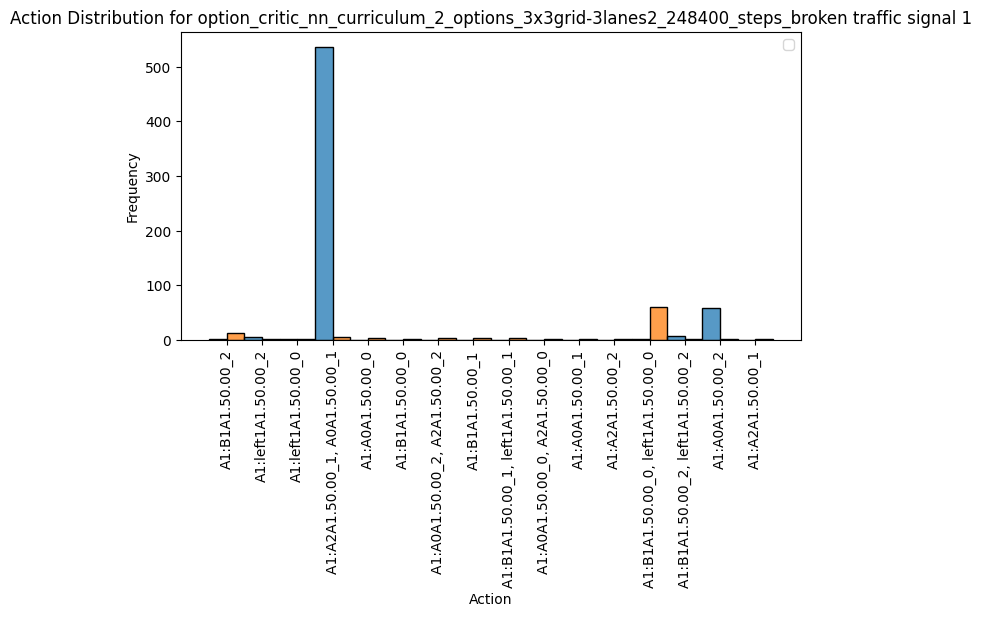

Results 3x3grid-3lanes translated_action_tf_2


/tmp/ipykernel_124445/2831421036.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


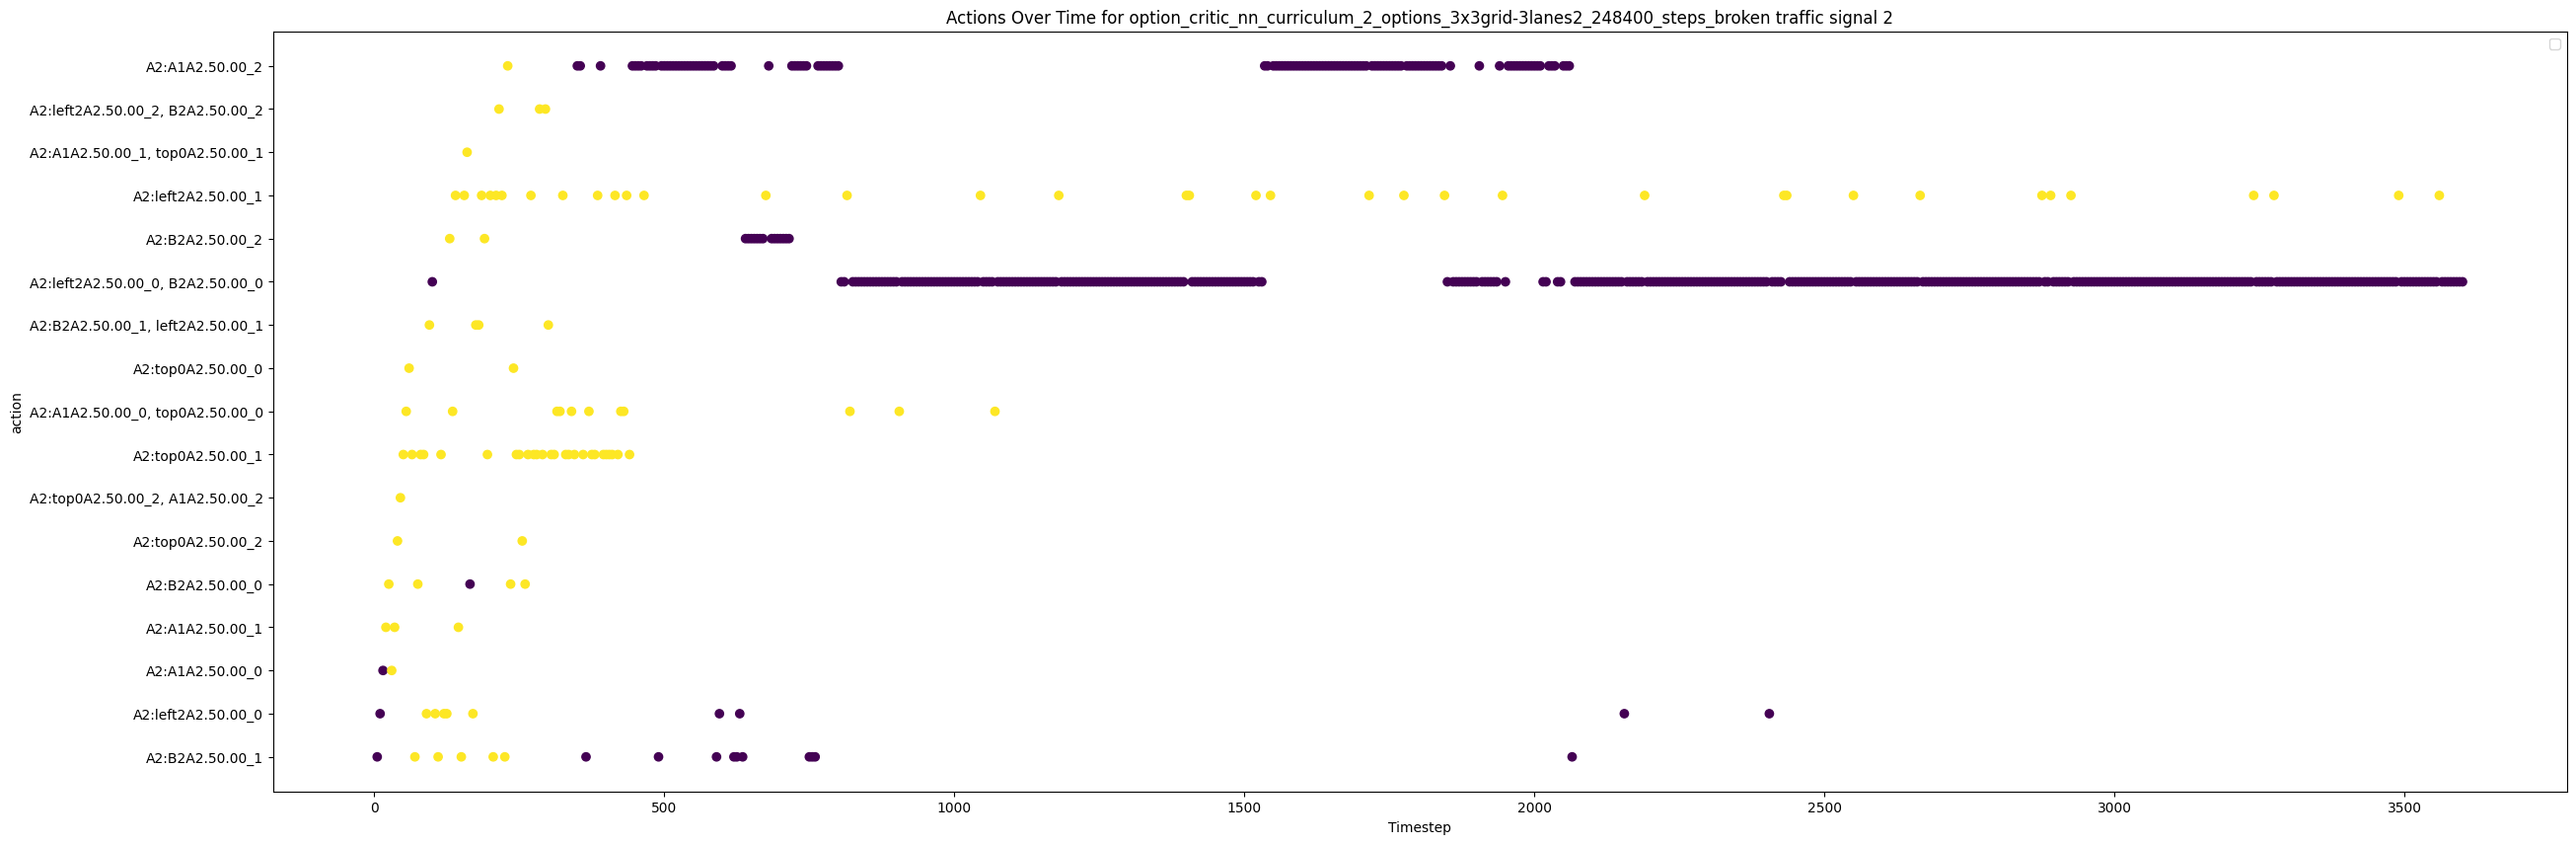

/tmp/ipykernel_124445/2831421036.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


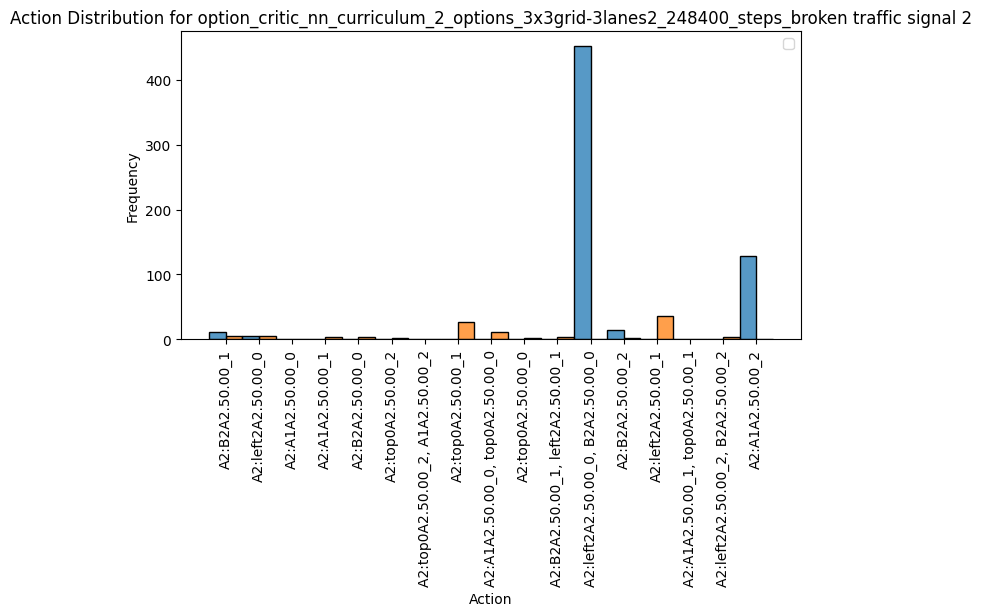

/tmp/ipykernel_124445/2831421036.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Results 3x3grid-3lanes translated_action_tf_3


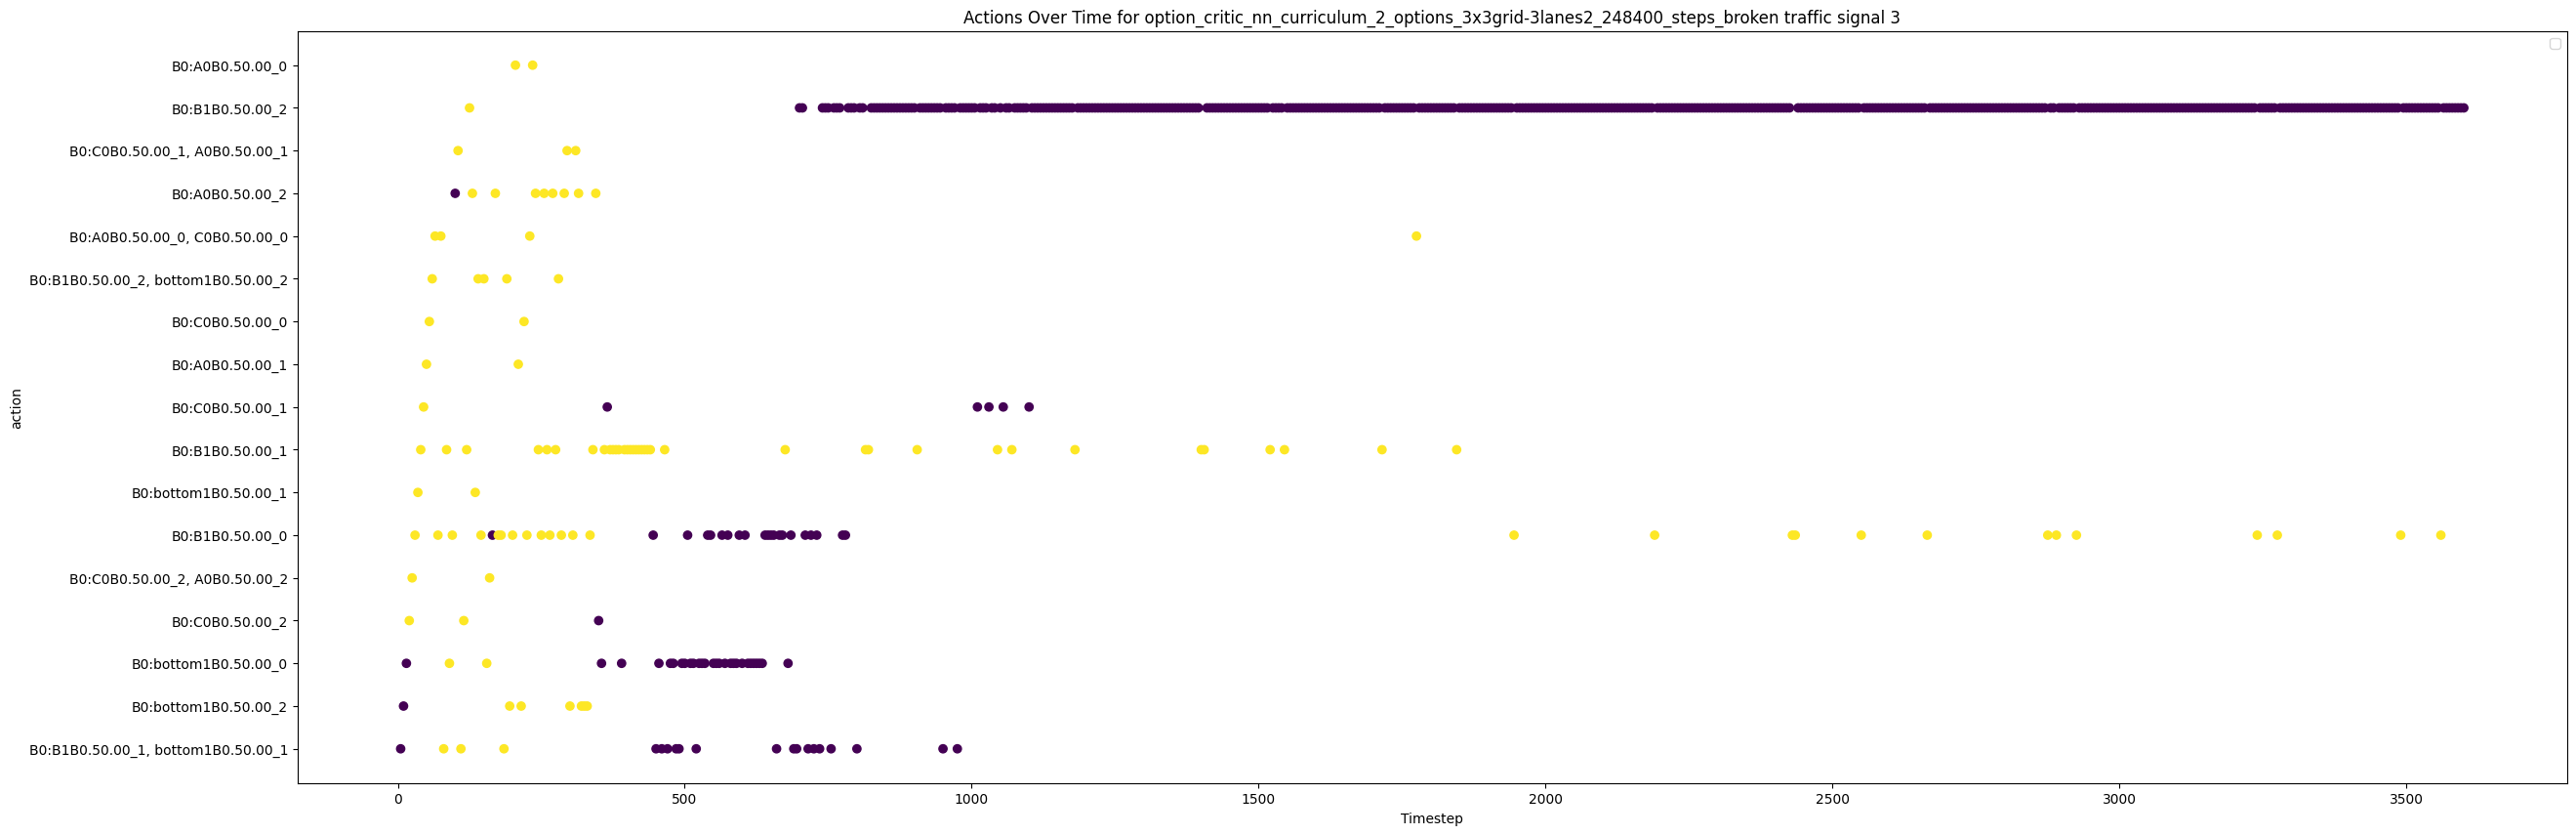

/tmp/ipykernel_124445/2831421036.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


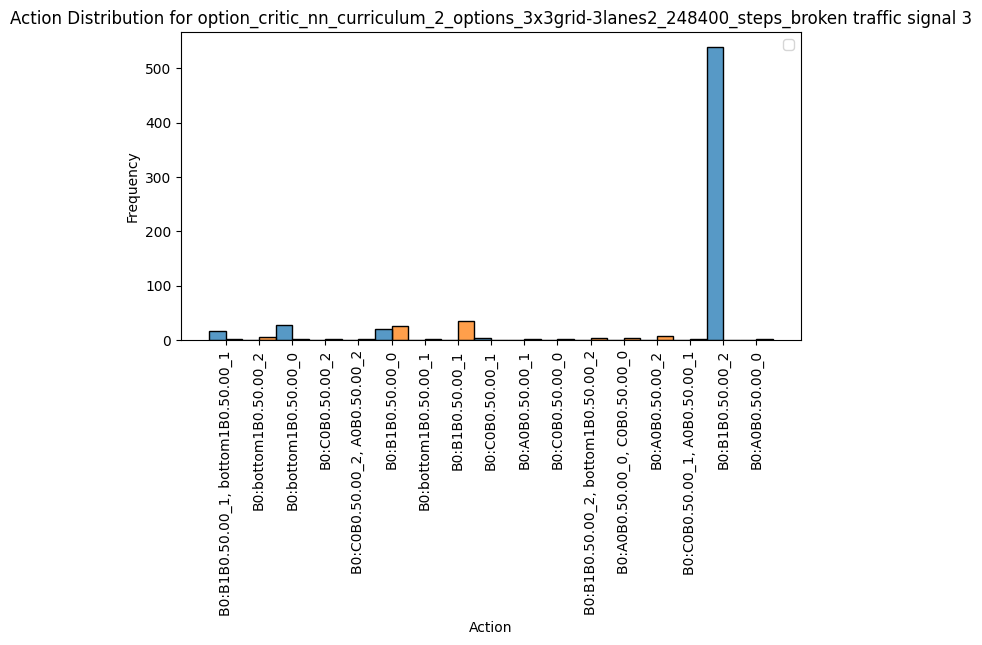

Results 3x3grid-3lanes translated_action_tf_4


/tmp/ipykernel_124445/2831421036.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


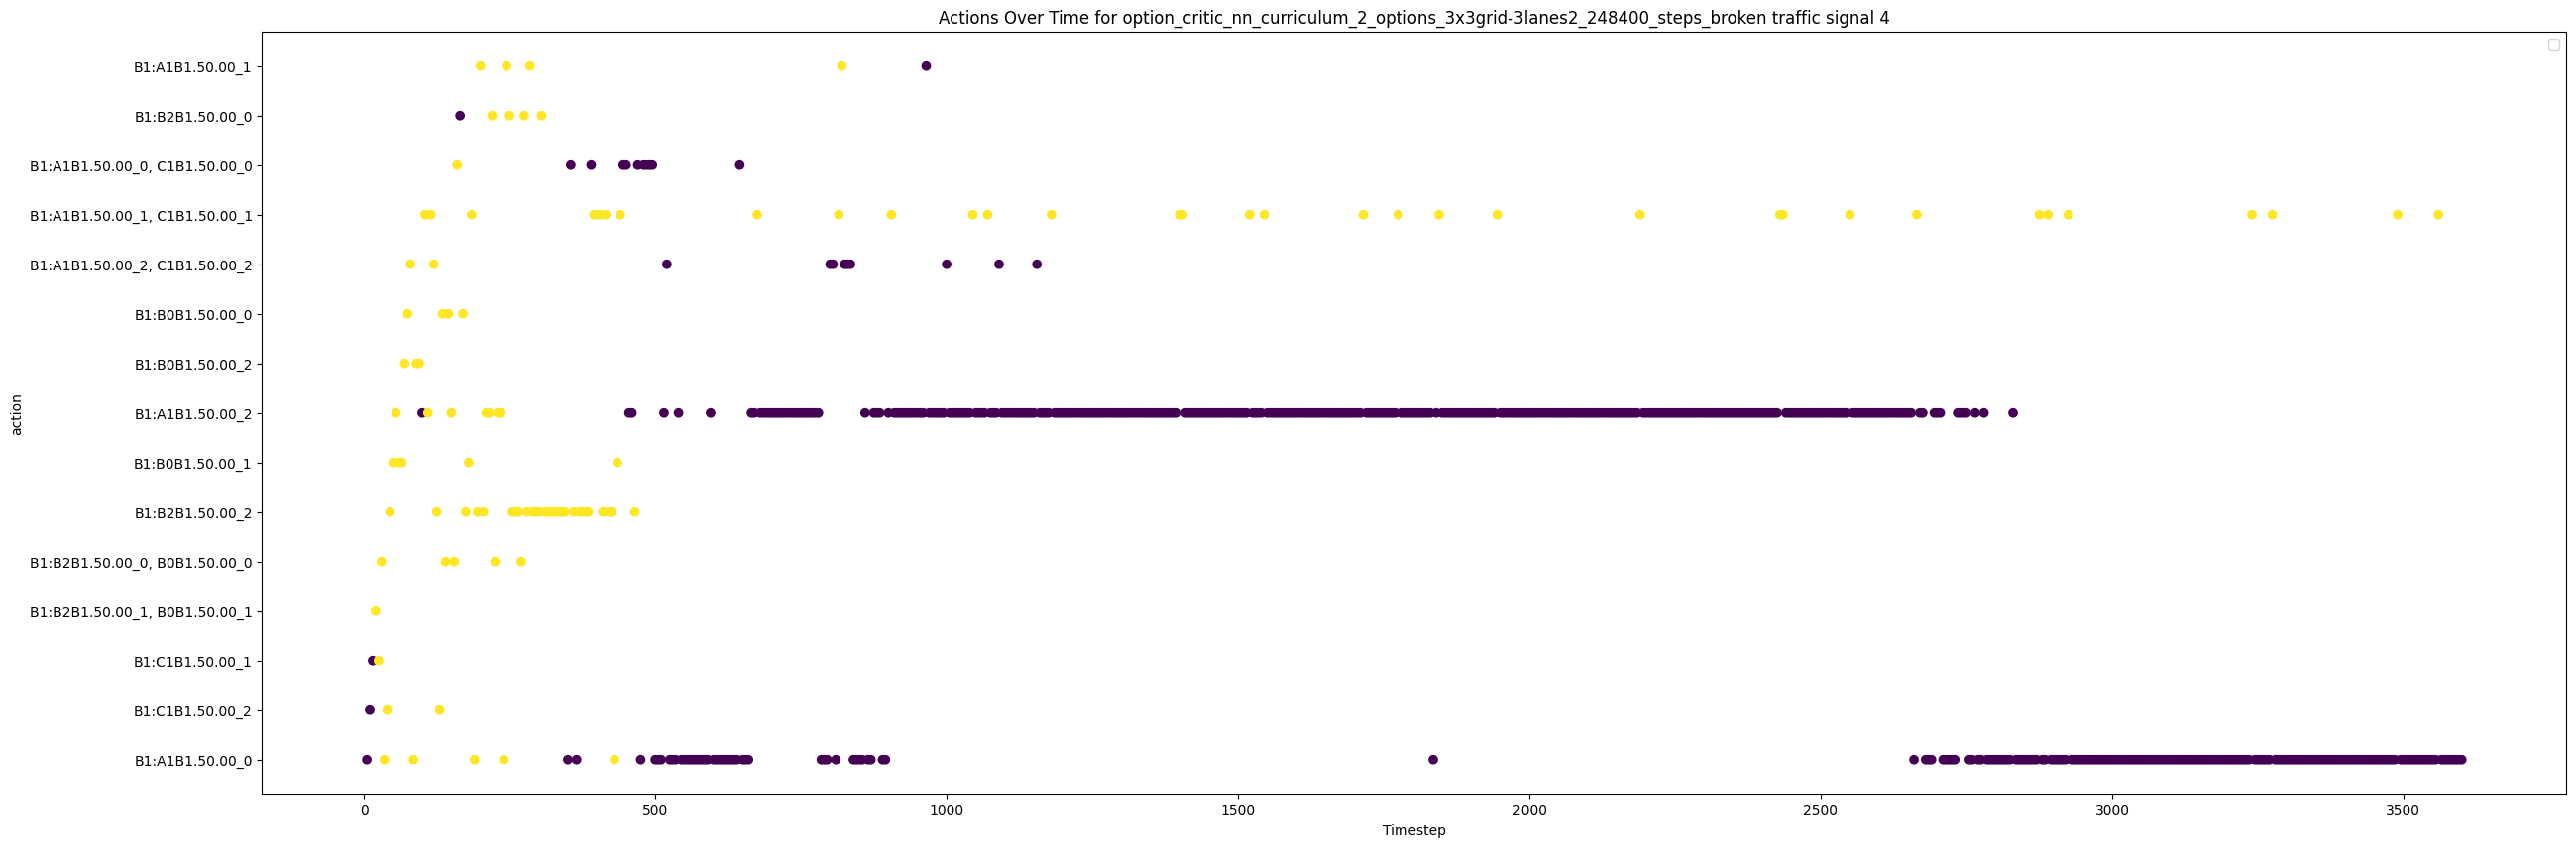

/tmp/ipykernel_124445/2831421036.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


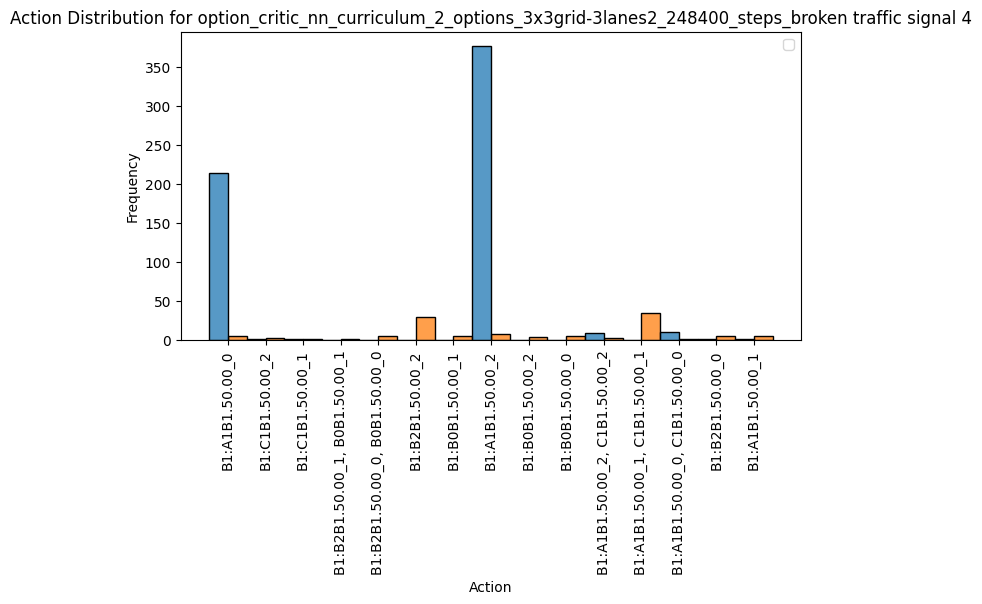

/tmp/ipykernel_124445/2831421036.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Results 3x3grid-3lanes translated_action_tf_5


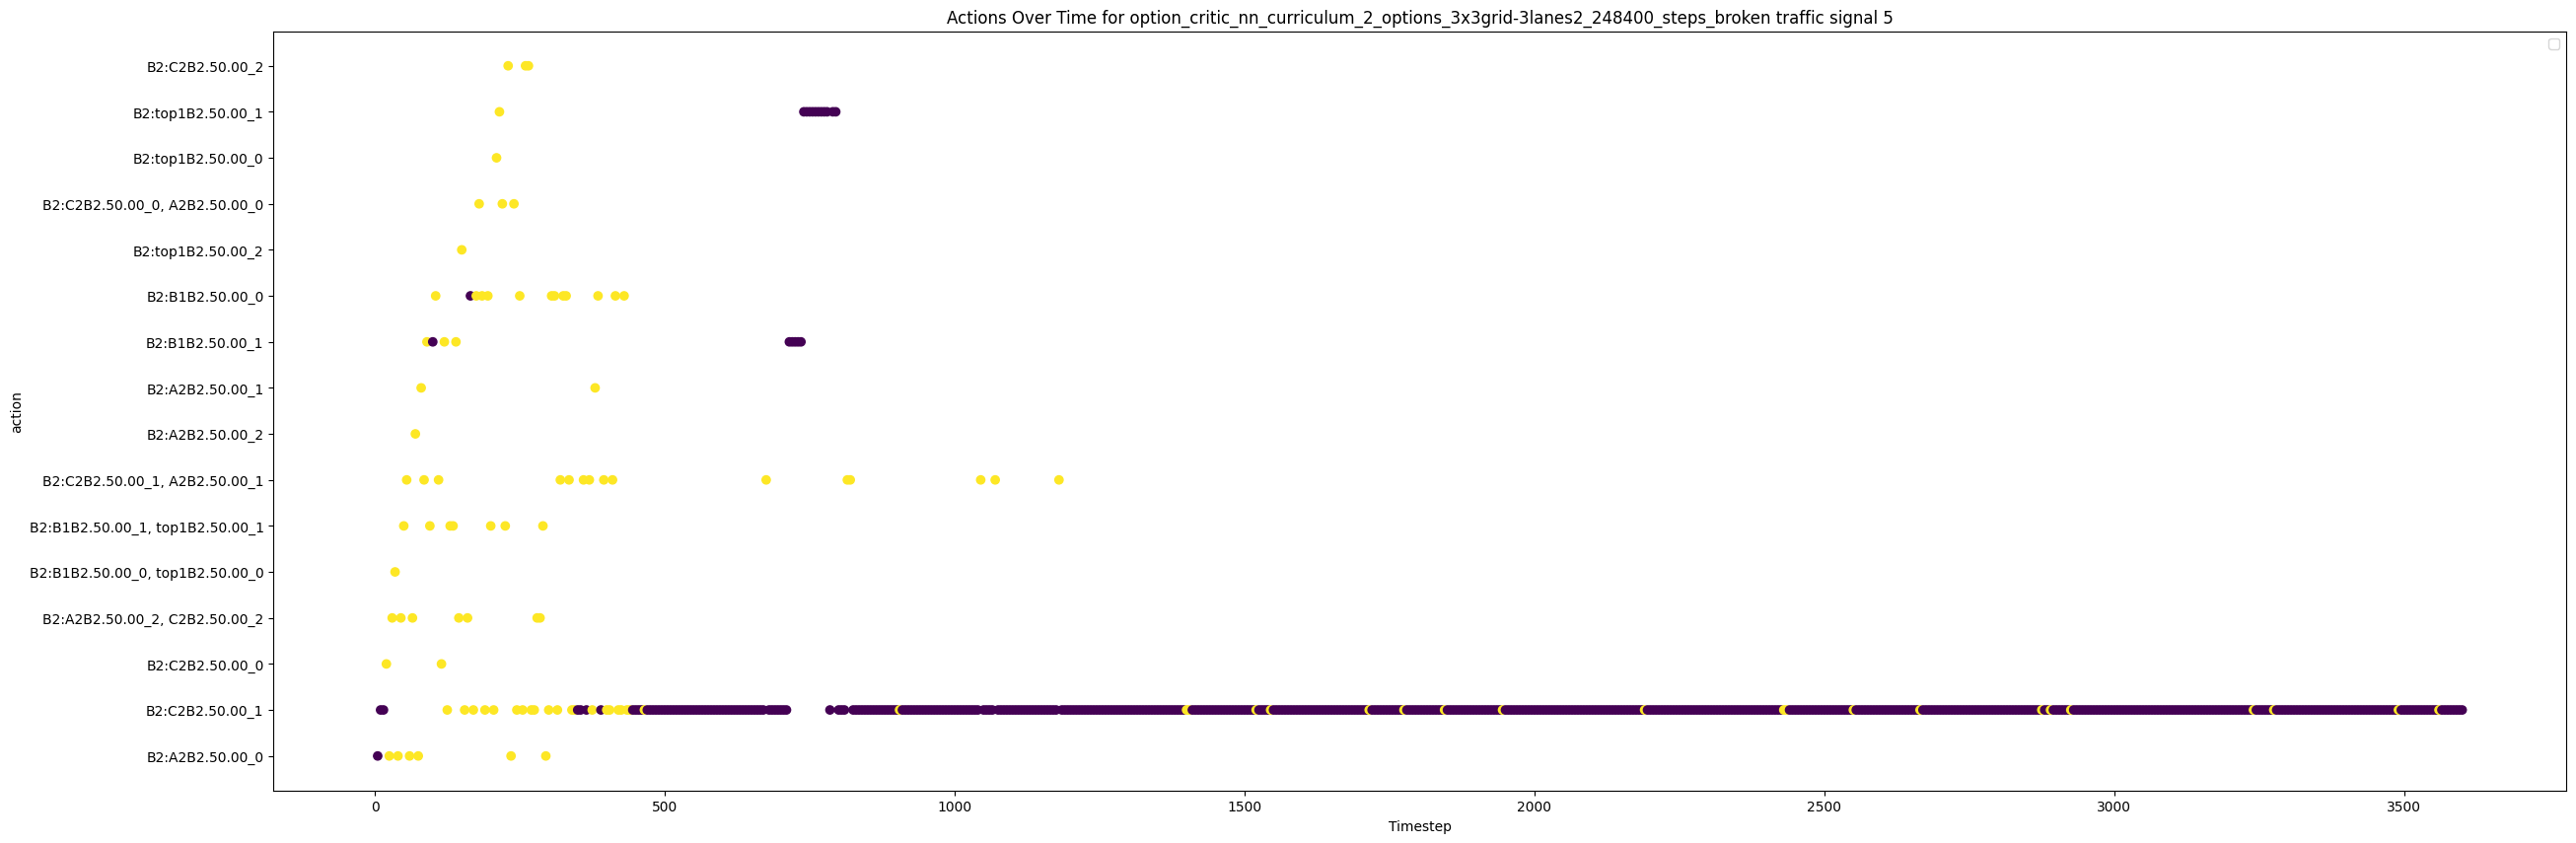

/tmp/ipykernel_124445/2831421036.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


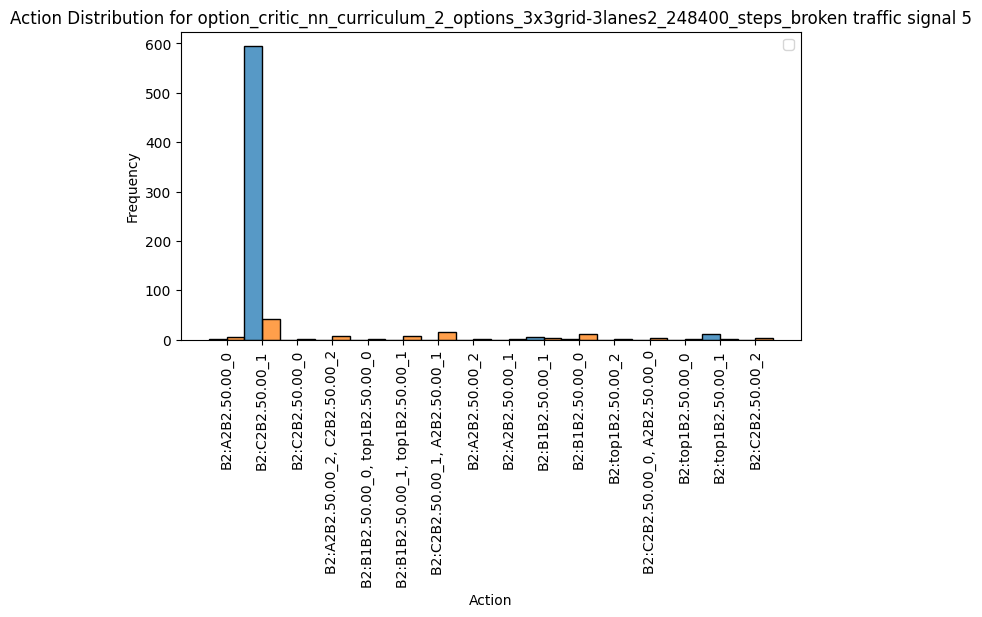

Results 3x3grid-3lanes translated_action_tf_6


/tmp/ipykernel_124445/2831421036.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


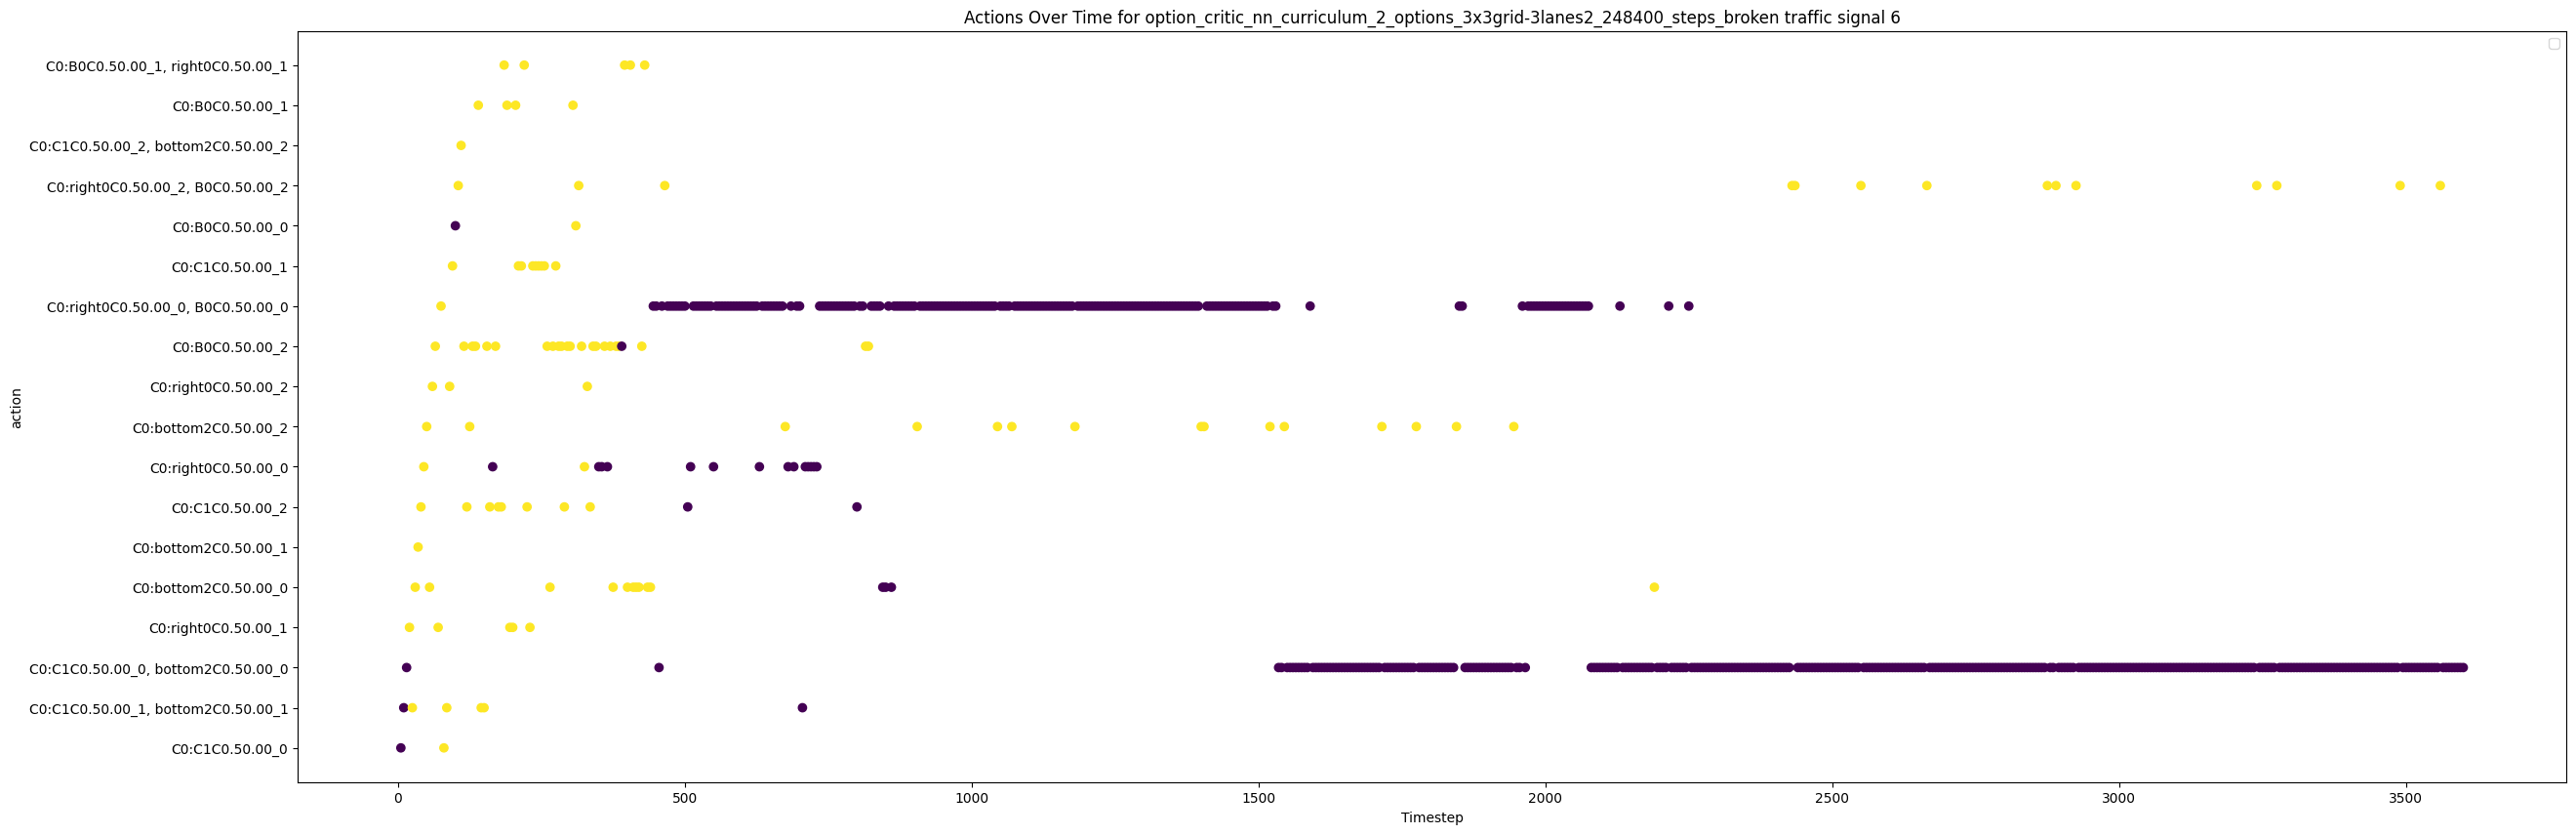

/tmp/ipykernel_124445/2831421036.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


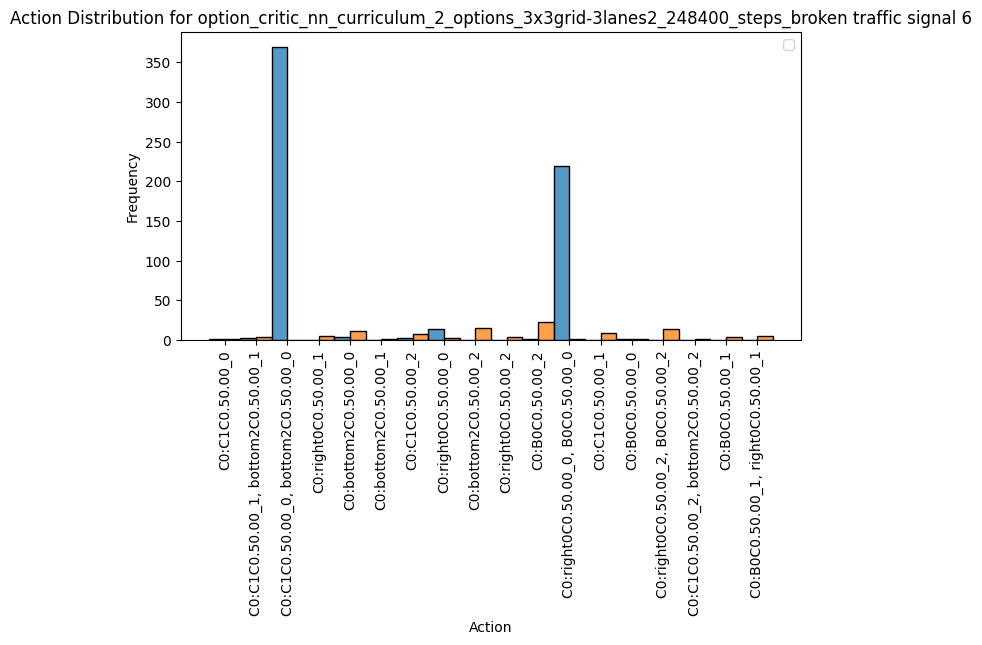

Results 3x3grid-3lanes translated_action_tf_7


/tmp/ipykernel_124445/2831421036.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


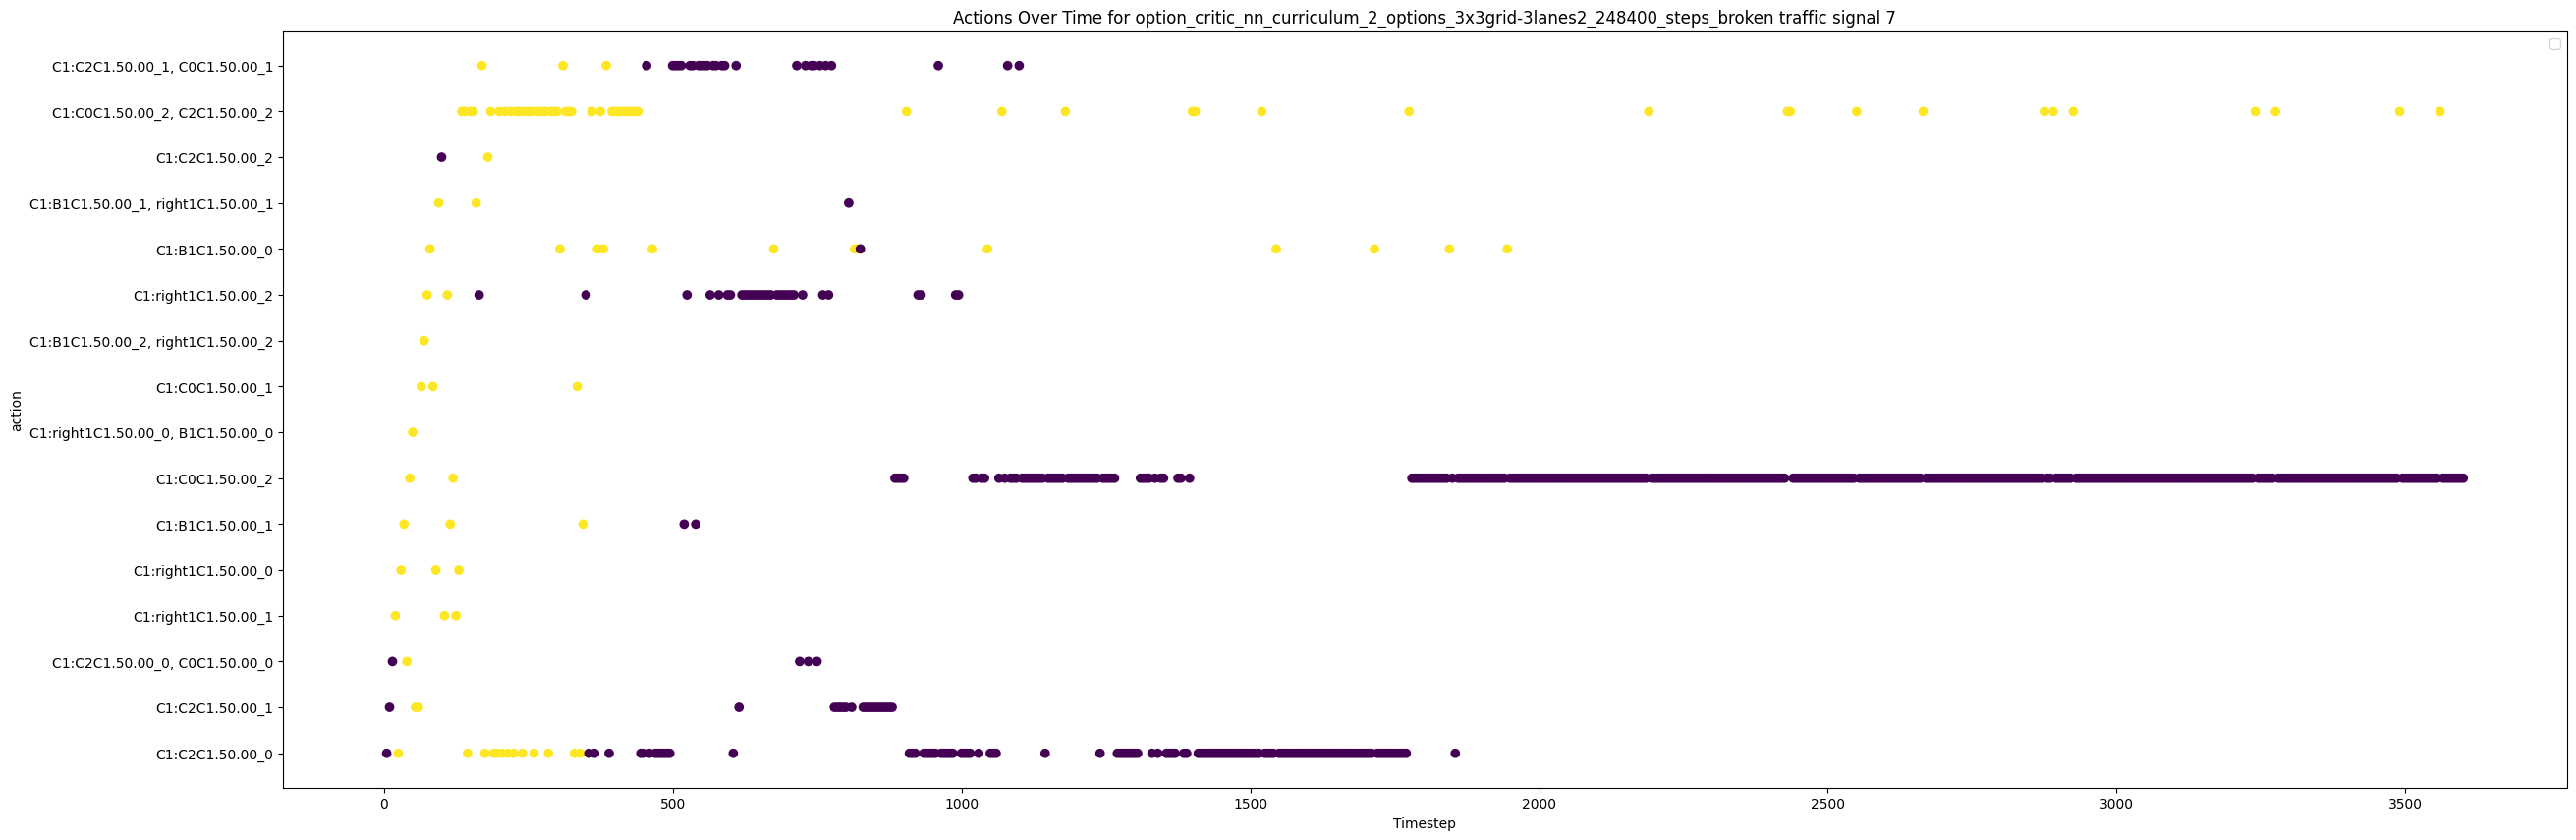

/tmp/ipykernel_124445/2831421036.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


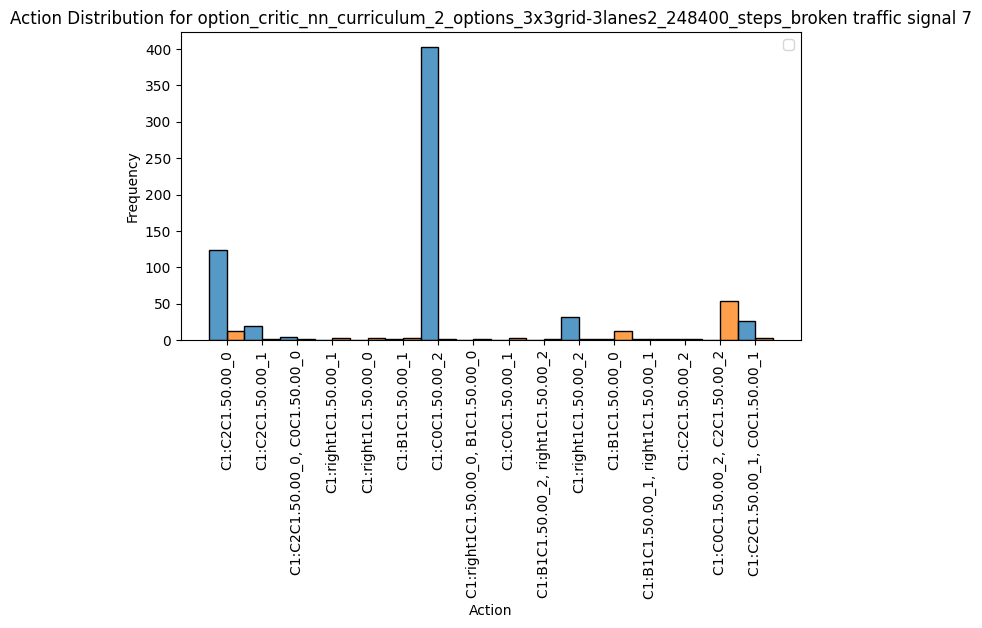

/tmp/ipykernel_124445/2831421036.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Results 3x3grid-3lanes translated_action_tf_8


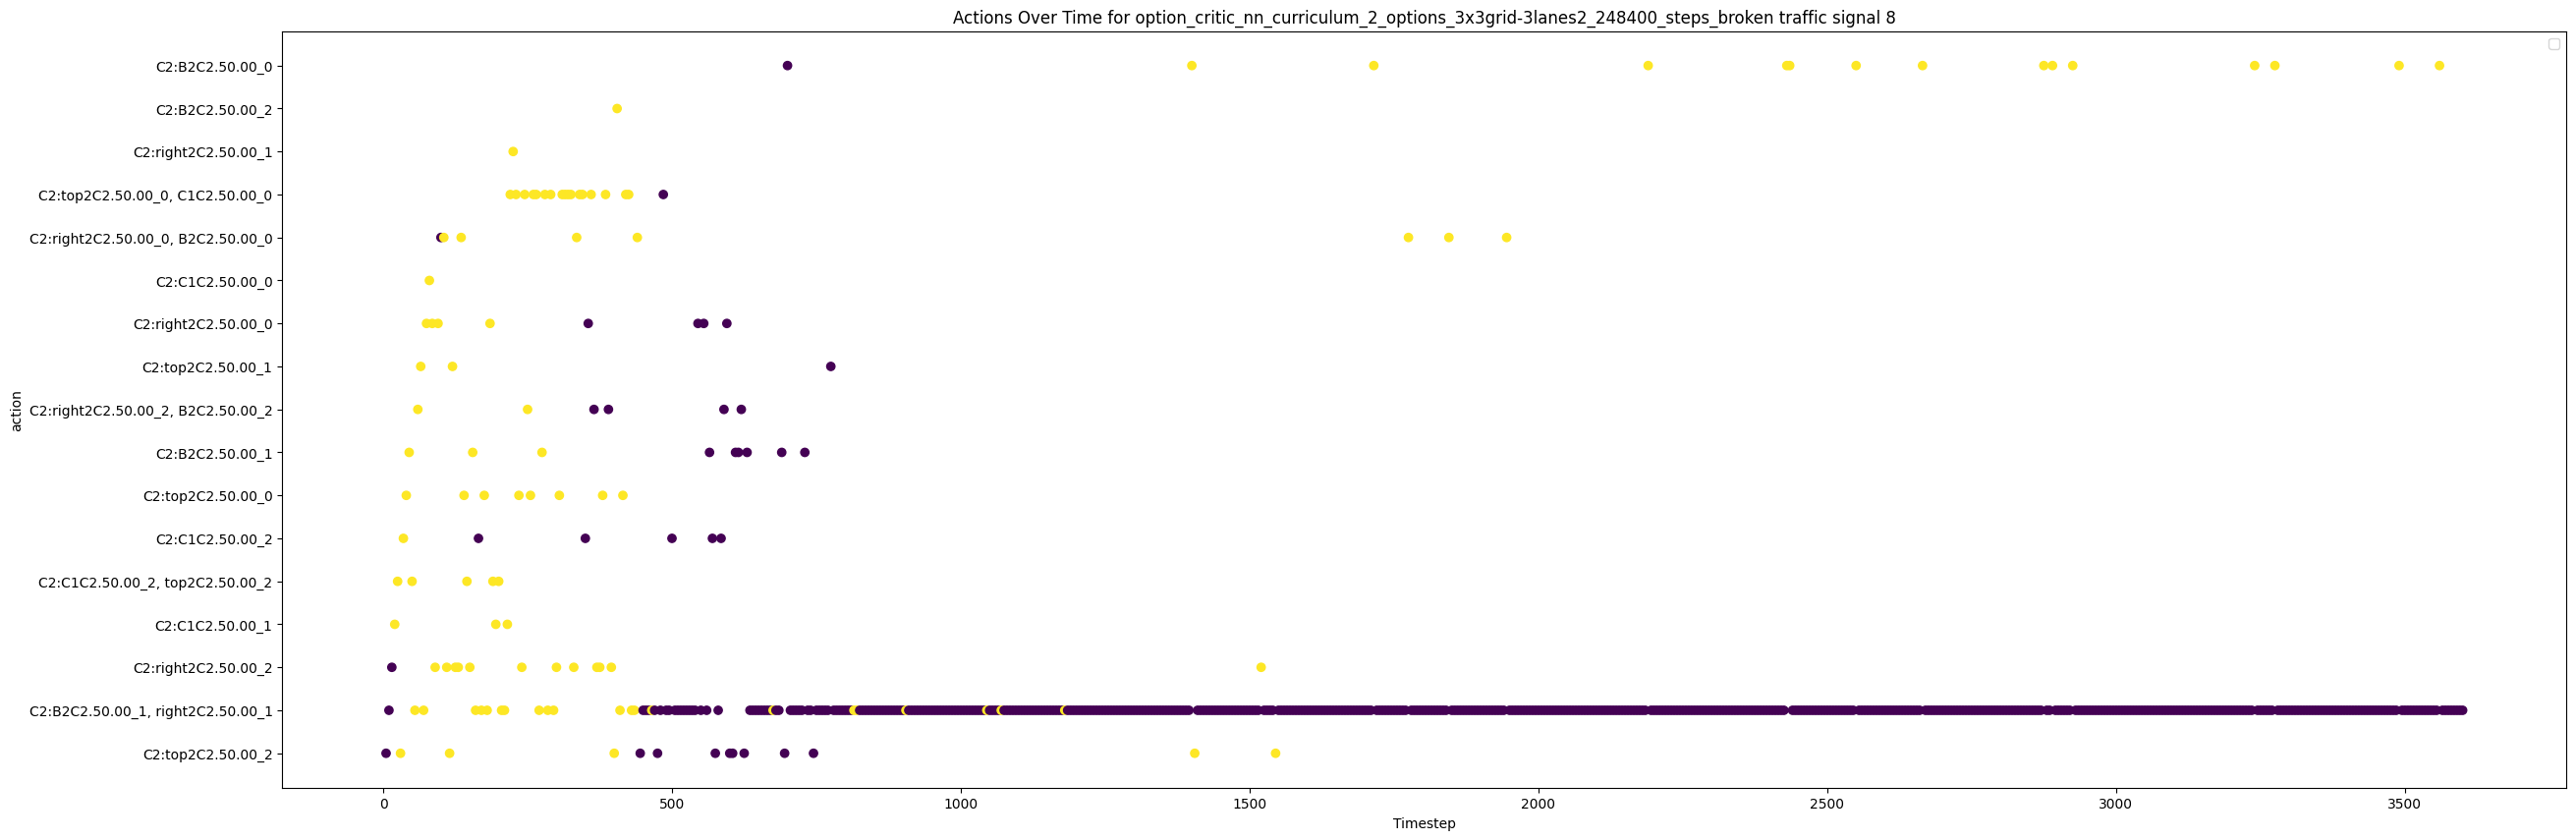

/tmp/ipykernel_124445/2831421036.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


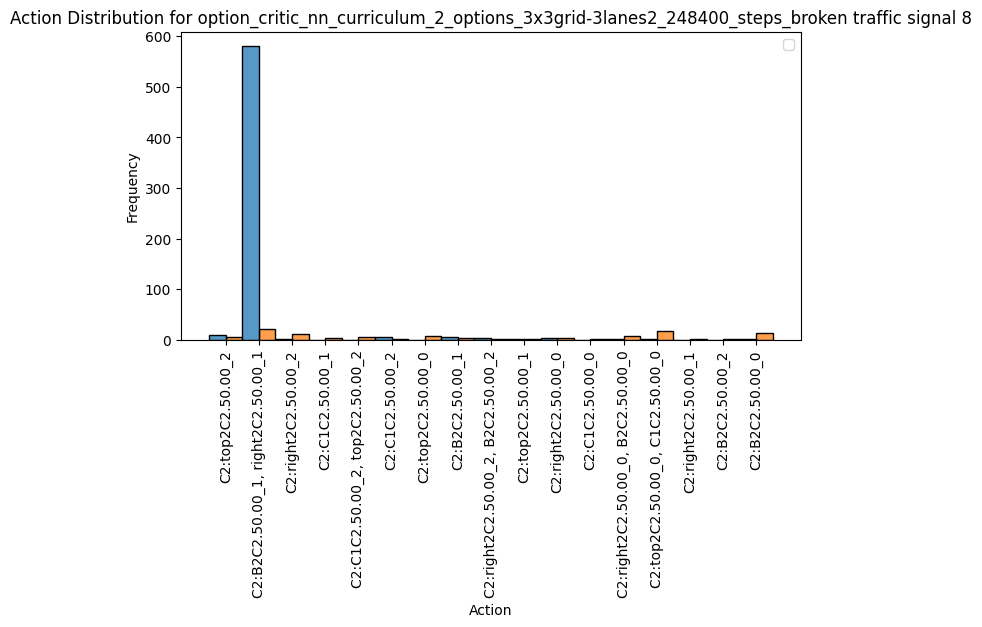

In [15]:
traffic = '3x3grid-3lanes'
n_splits = len(df_single_episode.translated_action.to_list()[0].split("; "))
for i in range(n_splits):
    column = f"translated_action_tf_{i}"
    print("Results", traffic, column)
        
    plt.figure(figsize=(30, 10))
    plt.scatter(df_single_episode.index, df_single_episode[f"{column}"], c=df_single_episode.option)

    plt.xlabel("Timestep")
    plt.ylabel("action")
    plt.title(f"Actions Over Time for {MODEL} traffic signal {i}")
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 4))
    sns.histplot(df_single_episode, x=column, hue="option", multiple="dodge")
    plt.xlabel("Action")
    plt.ylabel("Frequency")
    plt.title(f"Action Distribution for {MODEL} traffic signal {i}")
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()

In [11]:
df_single_episode

,option,action,obs,termination_prob,should_terminate,greedy_option,average_cumulative_reward,waiting_time,speed,lane_density,...,translated_action,translated_action_tf_0,translated_action_tf_1,translated_action_tf_2,translated_action_tf_3,translated_action_tf_4,translated_action_tf_5,translated_action_tf_6,translated_action_tf_7,translated_action_tf_8
step,,,,,,,,,,,,,,,,,,,,,
5.0,0,"[16, 11, 10, 1, 15, 15, 6, 6, 8]","{""A0"": {""current_phase_ids"": [1, 0, 0, 0, 0, 0...",0.582403,True,1,0.000000,0.000000,7.272553,0.000000,...,A0:left0A0.50.00_1; A1:B1A1.50.00_2; A2:B2A2.5...,A0:left0A0.50.00_1,A1:B1A1.50.00_2,A2:B2A2.50.00_1,"B0:B1B0.50.00_1, bottom1B0.50.00_1",B1:A1B1.50.00_0,B2:A2B2.50.00_0,C0:C1C0.50.00_0,C1:C2C1.50.00_0,C2:top2C2.50.00_2
10.0,0,"[4, 17, 15, 14, 11, 10, 1, 7, 4]","{""A0"": {""current_phase_ids"": [1, 0, 0, 0, 0, 0...",0.582403,True,1,-0.005556,0.000000,9.786907,0.056647,...,"A0:B0A0.50.00_1, left0A0.50.00_1; A1:left1A1.5...","A0:B0A0.50.00_1, left0A0.50.00_1",A1:left1A1.50.00_2,A2:left2A2.50.00_0,B0:bottom1B0.50.00_2,B1:C1B1.50.00_2,B2:C2B2.50.00_1,"C0:C1C0.50.00_1, bottom2C0.50.00_1",C1:C2C1.50.00_1,"C2:B2C2.50.00_1, right2C2.50.00_1"
15.0,0,"[6, 15, 12, 12, 10, 10, 0, 0, 11]","{""A0"": {""current_phase_ids"": [0, 0, 0, 0, 0, 0...",0.582403,False,1,-0.021944,0.000000,10.883659,0.113293,...,A0:A1A0.50.00_0; A1:left1A1.50.00_0; A2:A1A2.5...,A0:A1A0.50.00_0,A1:left1A1.50.00_0,A2:A1A2.50.00_0,B0:bottom1B0.50.00_0,B1:C1B1.50.00_1,B2:C2B2.50.00_1,"C0:C1C0.50.00_0, bottom2C0.50.00_0","C1:C2C1.50.00_0, C0C1.50.00_0",C2:right2C2.50.00_2
20.0,1,"[16, 15, 13, 11, 1, 9, 10, 10, 13]","{""A0"": {""current_phase_ids"": [0, 0, 0, 0, 0, 0...",0.508285,True,1,-0.054181,0.000000,9.668898,0.169940,...,A0:left0A0.50.00_1; A1:left1A1.50.00_0; A2:A1A...,A0:left0A0.50.00_1,A1:left1A1.50.00_0,A2:A1A2.50.00_1,B0:C0B0.50.00_2,"B1:B2B1.50.00_1, B0B1.50.00_1",B2:C2B2.50.00_0,C0:right0C0.50.00_1,C1:right1C1.50.00_1,C2:C1C2.50.00_1
25.0,1,"[2, 1, 9, 5, 10, 15, 1, 6, 2]","{""A0"": {""current_phase_ids"": [0, 0, 1, 0, 0, 0...",0.508251,True,1,-0.107027,1.000000,7.627359,0.226586,...,"A0:A1A0.50.00_2, bottom0A0.50.00_2; A1:A2A1.50...","A0:A1A0.50.00_2, bottom0A0.50.00_2","A1:A2A1.50.00_1, A0A1.50.00_1",A2:B2A2.50.00_0,"B0:C0B0.50.00_2, A0B0.50.00_2",B1:C1B1.50.00_1,B2:A2B2.50.00_0,"C0:C1C0.50.00_1, bottom2C0.50.00_1",C1:C2C1.50.00_0,"C2:C1C2.50.00_2, top2C2.50.00_2"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3580.0,0,"[9, 1, 3, 8, 15, 10, 0, 14, 4]","{""A0"": {""current_phase_ids"": [0, 0, 0, 0, 0, 0...",0.998528,True,0,-20058.459259,1772.017308,0.030912,25.634441,...,"A0:B0A0.50.00_0; A1:A2A1.50.00_1, A0A1.50.00_1...",A0:B0A0.50.00_0,"A1:A2A1.50.00_1, A0A1.50.00_1","A2:left2A2.50.00_0, B2A2.50.00_0",B0:B1B0.50.00_2,B1:A1B1.50.00_0,B2:C2B2.50.00_1,"C0:C1C0.50.00_0, bottom2C0.50.00_0",C1:C0C1.50.00_2,"C2:B2C2.50.00_1, right2C2.50.00_1"
3585.0,0,"[9, 1, 3, 8, 15, 10, 0, 14, 4]","{""A0"": {""current_phase_ids"": [0, 0, 0, 0, 0, 0...",0.998528,True,0,-20108.069629,1773.596929,0.033796,25.577795,...,"A0:B0A0.50.00_0; A1:A2A1.50.00_1, A0A1.50.00_1...",A0:B0A0.50.00_0,"A1:A2A1.50.00_1, A0A1.50.00_1","A2:left2A2.50.00_0, B2A2.50.00_0",B0:B1B0.50.00_2,B1:A1B1.50.00_0,B2:C2B2.50.00_1,"C0:C1C0.50.00_0, bottom2C0.50.00_0",C1:C0C1.50.00_2,"C2:B2C2.50.00_1, right2C2.50.00_1"
3590.0,0,"[9, 1, 3, 8, 15, 10, 0, 14, 4]","{""A0"": {""current_phase_ids"": [0, 0, 0, 0, 0, 0...",0.998528,True,0,-20157.716148,1778.577735,0.037942,25.691088,...,"A0:B0A0.50.00_0; A1:A2A1.50.00_1, A0A1.50.00_1...",A0:B0A0.50.00_0,"A1:A2A1.50.00_1, A0A1.50.00_1","A2:left2A2.50.00_0, B2A2.50.00_0",B0:B1B0.50.00_2,B1:A1B1.50.00_0,B2:C2B2.50.00_1,"C0:C1C0.50.00_0, bottom2C0.50.00_0",C1:C0C1.50.00_2,"C2:B2C2.50.00_1, right2C2.50.00_1"


In [ ]:
df_single_episode

In [ ]:
densities = []
for index in range(df_single_episode.shape[0]):
    obs, current_option, unnested_dict = get_obs(df_single_episode, index)
    density_dict = {}
    with open(f"{META_FOLDER}/{TRAFFIC}.json") as f:
        meta_data = json.load(f)
    
    lanes = {
        key: value["lanes"]["incoming"]
        for key, value in meta_data.items()
    }
    for key, value in unnested_dict.items():
        if "density" in key:
            tf_id = key.split("_")[0]
            new_key = key[:-1] + lanes[tf_id][key[-1]]
            density_dict[new_key] = value
    densities.append(density_dict)
df_densities = pd.DataFrame(densities)

In [ ]:
plt.figure(figsize=(20, 10))

for column in df_densities.columns:
    plt.plot(df_densities.index, df_densities[column], label=column)

plt.legend()
plt.title("Densities")
plt.xlabel("Index")
plt.ylabel("Density")
plt.show()

In [ ]:
with open(f"{META_FOLDER}/{TRAFFIC}.json") as f:
    meta_data = json.load(f)

for tf_id in meta_data:
    plt.figure(figsize=(20, 10))

    for column in df_densities.columns:
        if column.startswith(tf_id):
            plt.plot(df_densities.index, df_densities[column], label=column)

    plt.legend()
    plt.title(f"Densities {tf_id}")
    plt.xlabel("Index")
    plt.ylabel("Density")
    plt.show()

In [ ]:
with open(f"{META_FOLDER}/{TRAFFIC}.json") as f:
    meta_data = json.load(f)

model_params = torch.load(
    f"{MODELS_FOLDER}/{MODEL}"
)

q_model_params = model_params['Q']
termination_network_params = model_params['terminations']

termination_model = TerminationFunctionNetwork(obs_size=list(termination_network_params.values())[0].shape[1],
                                               n_options=list(termination_network_params.values())[-1].shape[0],
                                              device="cpu")

termination_model.load_state_dict(termination_network_params)

q_model = ReluNetwork(input_size=list(q_model_params.values())[0].shape[1],
                      output_size=list(q_model_params.values())[-1].shape[0],
                      device="cpu")

q_model.load_state_dict(q_model_params)

option_policies = {}
for option in range(N_OPTIONS):
    option_policy_model_params = model_params[f'option_policy_{option}']
    heads = [key for key in list(option_policy_model_params.keys()) if key.startswith("heads") and key.endswith("weight")]
    option_policy_model = MultiDiscreteReluNetwork(input_size=list(option_policy_model_params.values())[0].shape[1],
                      action_sizes=[len(option_policy_model_params[head]) for head in heads],
                      device="cpu")
    option_policy_model.load_state_dict(option_policy_model_params)

    option_policies[option] = option_policy_model


In [ ]:
obs, current_option, unnested_dict = get_random_obs(df_single_episode)
state = prep_state(obs, current_option)
state = state.clone().detach().requires_grad_(True)
# Forward pass
termination_prob = termination_model(state)[:, current_option]

# Compute gradients w.r.t input state
termination_prob.backward()

# Get absolute gradient values (saliency)
saliency = state.grad.abs().detach().numpy()

# Normalize for visualization
saliency /= saliency.max()

# Plot saliency map
plt.figure(figsize=(20, 5))
sns.heatmap(saliency.reshape(1, -1), annot=True, cmap="coolwarm", cbar=True, linewidths=0.5)
plt.title("Saliency Map for Termination Function")
plt.ylabel("State Features")
plt.show()

In [ ]:
for index, key in enumerate(unnested_dict):
    print(index, key)

In [ ]:
for index in range(1000):
    obs, current_option, unnested_dict = get_obs(df_single_episode, index)
#     print(index, json.dumps(unnested_dict, indent=4))
    state = prep_state(obs, current_option)
    print("==============")
    print(index * 5, "option", current_option, "termination prob", df_single_episode.termination_prob.to_list()[index], "\n", 
          "Q", q_model(state),
          "\n", "termination", termination_model(state))
    for option, policy in option_policies.items():
        raw_action_dist = policy(state)
        action_dist = Categorical(logits=raw_action_dist)
        action = action_dist.sample()
        print("Option", option, "action", action, "\n", "raw_action_dist", raw_action_dist,"\n", "action_dist", action_dist.probs)


In [ ]:
def create_feature_df(df):
    feature_list = []
    option_list = df.option.to_list()
    for index, obs_item in enumerate(df.obs.to_list()):
        unnested_obs = {}
        for tf_id, observation_dict in json.loads(obs_item).items():
            for key, value in observation_dict.items():
                if isinstance(value, list):
                    for index, item in enumerate(value):
                        unnested_obs[f"{tf_id}_{key}_{index}"] = item
                else:
                    unnested_obs[f"{tf_id}_{key}"] = value
        current_option = int(option_list[index])
        for o in range(N_OPTIONS):
            key = f"option_{o}"
            if o == current_option:
                value = 1
            else:
                value = 0
            unnested_obs[f"{tf_id}_{key}"] = value
                    
        feature_list.append(unnested_obs)
    return pd.DataFrame(feature_list)

features = create_feature_df(df_single_episode)

In [ ]:
def f(X):
    results = []
    for record in X:
        record = to_tensor([record])
        state = prep_state(record)
        prob = termination_model(state).sigmoid()
        max_prob = np.max(prob.detach().numpy())
        results.append(max_prob)
    return np.array(results)
explainer = shap.KernelExplainer(f, features.iloc[:50, :])
shap_values = explainer.shap_values(features.iloc[:, :], nsamples=50)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, features)

In [ ]:
shap.initjs()
shap.decision_plot(explainer.expected_value, shap_values, features)

In [ ]:
def f_q_values(X):
    results = []
    for record in X:
        record = to_tensor([record])
        state = prep_state(record)
        prob = q_model(state).sigmoid()
        max_prob = np.max(prob.detach().numpy())
        results.append(max_prob)
    return np.array(results)
explainer_q_model = shap.KernelExplainer(f_q_values, features.iloc[:50, :])
shap_values_q_model = explainer_q_model.shap_values(features.iloc[:, :], nsamples=50)

In [ ]:
shap.initjs()
shap.force_plot(shap_values_q_model.expected_value, shap_values_q_model, features)

In [ ]:
shap.initjs()
shap.decision_plot(shap_values_q_model.expected_value, shap_values_q_model, features)

In [ ]:
##########
# Backup #
##########

In [ ]:
states = df_single_episode.obs.to_list()
options = df_single_episode.option.to_list()
n = df_single_episode.shape[0]
G = nx.DiGraph()

# Add nodes with positions
node_colors = []
for i in range(n):
    G.add_node(states[i], option=options[i])
    node_colors.append(options[i])

# Add directed edges based on actions
for i in range(n - 1):
    G.add_edge(i, i + 1, action=i)

# Draw graph
plt.figure(figsize=(8, 6))
print("Drawing graph")
nx.draw(
    G, with_labels=True,cmap=plt.cm.viridis,
    edge_color="gray", node_size=300, font_size=8, font_color="white",
    arrows=True, arrowsize=10
)

sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis)

plt.title("State-Action Network with Termination States")
plt.show()

In [ ]:
model_params = torch.load(
    f"./models/{MODEL}"
)

q_model_params = {}
termination_network_params = {}

for key, value in model_params.items():
    if key.startswith('Q'):
        q_model_params[key] = value
    elif key.startswith("terminations"):
        termination_network_params[key] = value
    else:
        print(f"Unknown key {key}")

termination_model = TerminationFunctionNetwork(obs_size=list(termination_network_params.values())[0].shape[1],
                                               n_options=list(termination_network_params.values())[-1].shape[0],
                                              device="cpu")
q_model = ReluNetwork(obs_size=list(q_model_params.values())[0].shape[1],
                      action_size=list(q_model_params.values())[-1].shape[0],
                      device="cpu")